- The main objective is to predict people with pre-diabetes. 
- In this file, both data files will be combined and exploratory data analysis will be performed on the final data,
- Cleaning will be done side wise side wherever it is required and final data will be saved in s3

In [1]:
!pip install --upgrade pandas --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [2]:
!pip install --upgrade numpy --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [3]:
!pip install awswrangler --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [4]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import boto3
import io

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [5]:
s3 = boto3.client('s3')

# Mention the bucket name where raw data is present
bucket='adl-core-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# Mention the version whre data is stored in given S3 bucket
version = 'version-1'

# Mention the correct directory where raw-data is present, if data is in multiple files make sure all files are present in this directory
raw_data_path = f'external/artichauhan/Pre-Diabetes/Raw Data'
raw_data_path2 = f'external/artichauhan/Pre-Diabetes 2/Raw Data'
preprocessed_data = f'external/artichauhan/Pre-Diabetes 2/Preprocessed-Data'

raw_data_fnames = ['Hype_ML_demographics_19_20_21_1.csv','Hype_ML_demographics_19_20_21_2.csv']

s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes/Raw Data/data in parquet format/

In [6]:
# # Retrieve the list of existing buckets
# s3 = boto3.client("s3")
# response = s3.list_buckets()

# # Output the bucket names
# print("Existing buckets:")
# for bucket in response['Buckets']:
#     print(f'{bucket["Name"]}')

In [7]:
#s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes 2/Raw Data/Data in parquet forrmat/

In [8]:
# df = dd.read_parquet(f's3://{bucket}/{raw_data_path2}/Data in parquet format/*.parquet')
# #converting dask df to pandas df 
# df = df.compute()
# df.head()

In [9]:
import awswrangler as wr
df = wr.s3.read_parquet(f's3://{bucket}/{raw_data_path2}/Data in parquet format')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664653 entries, 0 to 214786
Data columns (total 94 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   person_internal_id                     664653 non-null  Int32  
 1   partneremployerid                      664653 non-null  Int32  
 2   patient_key                            664653 non-null  Int32  
 3   pre_diabetic_label                     664653 non-null  string 
 4   tot_billed_amt_yr_0                    664653 non-null  float64
 5   avg_billed_amt_yr_0                    664653 non-null  float64
 6   std_billed_amt_yr_0                    664653 non-null  float64
 7   max_billed_amt_yr_0                    664653 non-null  float64
 8   employer_paid_yr_0                     664653 non-null  float64
 9   employee_paid1_yr_0                    664653 non-null  float64
 10  employee_paid2_yr_0                    664653 non-null  

In [11]:
df.shape

(664653, 94)

In [12]:
df['pre_diabetic_label'].unique()

<StringArray>
['No', 'Yes']
Length: 2, dtype: string

In [13]:
len(df[df['pre_diabetic_label'] == 'NULL']['pre_diabetic_label'])

0

In [14]:
round(len(df[df['pre_diabetic_label'] == 'NULL']['pre_diabetic_label'])/len(df.index),2)

0.0

In [15]:
df.isna().sum()

person_internal_id        0
partneremployerid         0
patient_key               0
pre_diabetic_label        0
tot_billed_amt_yr_0       0
                         ..
primary_care_ind_y1       0
physician_ind_y18         0
unknown_ind_y1            0
durable_medical_ind_y1    0
lab_visit_ind_y1          0
Length: 94, dtype: int64

In [16]:
threshold = 0.1
na_col = df.isna().sum().div(len(df.index))              # average na by column
cols = na_col[na_col > threshold].keys().to_list() 
print(cols)

[]


In [17]:
def load_data_from_s3(bucket,raw_data_path,raw_data_fnames):
    s3 = boto3.client('s3')
    dataset_nrows = []
    for i, fname in enumerate(raw_data_fnames):
        if i==0:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data = pd.read_csv(io.BytesIO(obj['Body'].read()))
            dataset_nrows.append(data.shape[0])
            print(f'\tFile read successfully | Shape: {data.shape}')
        else:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data2 = pd.read_csv(io.BytesIO(obj['Body'].read()))
            data = data.append(data2,ignore_index=True)
            dataset_nrows.append(data2.shape[0])
            print(f'\tFile read successfully | Shape: {data2.shape}')

    if sum(dataset_nrows) == data.shape[0]:
        print(f'Data from all files loaded successfully | Final Shape: {data.shape}')
        return data.copy()
    else:
        print('There is discrepency in numbers')
        print(f'\tTotal number of rows combined in all files: {sum(dataset_nrows)}')
        print(f'\tAfter combining all files total number of rows are: {data.shape[0]}')
        return None

In [18]:
data_path = f'{raw_data_path}/Demographics files'
demo_df = load_data_from_s3(bucket,data_path,raw_data_fnames)

Reading file: Hype_ML_demographics_19_20_21_1.csv
	File read successfully | Shape: (2242551, 35)
Reading file: Hype_ML_demographics_19_20_21_2.csv
	File read successfully | Shape: (2082214, 35)
Data from all files loaded successfully | Final Shape: (4324765, 35)


In [19]:
demo_df.head(2)

,person_internal_id,client_id,udp_global_id,age,gender,marital_status,is_union,primary_language_code,country_description,state,platform_indicator_code,mapped_employment_status_code,mapped_employment_status_description,mapped_fullpart_code,mapped_fullpart_description,mapped_high_compensation_code,mapped_high_compensation_description,mapped_permanent_temporary_code,mapped_permanent_temporary_description,mapped_hourly_salary_code,mapped_hourly_salary_description,subsidiary_code,subsidiary_description,mapped_flex_status_code,mapped_flex_status_description,original_hire_date,rehire_date,is_rehire,termination_date,base_pay_regular_payrate_amount,base_pay_regular_frequency_code,base_pay_regular_frequency_description,base_pay_regular_expectedannualsalary,base_pay_regular_expectedannualsalary_range,annual_benefits_base_rate
0,359000077,3349,58a39c4f042fec2f071a7119,74.0,F,S,N,NaN,United States of America,TX,R4,RTEE,Retired,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,1970-02-27,NaN,N,2299-12-31,35626.50,A1,Annual,35626.50,"$20,000-$39,999",NaN
1,231200007,3955,59056881dab54b31271989ea,58.0,M,M,N,AE,United States of America,MD,R4,ACTIVE,Active,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,NaN,NaN,N,2299-12-31,104499.24,A1,Annual,104499.24,"$100,000-$174,999",NaN


In [20]:
# At first I am taking only these columns from demographicdata
demo_df = demo_df[['client_id','person_internal_id','age','gender','marital_status','mapped_employment_status_code']]

In [21]:
demo_df['client_pid'] = demo_df['client_id'].astype(str) + '/' +  demo_df['person_internal_id'].astype(str)

In [22]:
df['client_pid'] = df['partneremployerid'].astype(str) + '/' +  df['person_internal_id'].astype(str)

In [23]:
pd_df = df.merge(demo_df,how='left',on='client_pid')

In [24]:
pd_df.head(2)

,person_internal_id_x,partneremployerid,patient_key,pre_diabetic_label,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,preventive_visit_flag_yr_0,blood_glucose_test_flag_yr_0,hypertension_flag_yr_0,obesity_flag_yr_0,family_history_diabetes_flag_yr_0,physical_excercise_flag_yr_0,dietary_counselling_flag_yr_0,screening_diabetes_mellitus_flag_yr_0,sleep_apnea_flag_yr_0,cushing_syndrome_flag_yr_0,acromegaly_flag_yr_0,polyuria_flag_yr_0,nocturia_flag_yr_0,polydipsia_flag_yr_0,ovarian_disorder_flag_yr_0,heart_disorder_flag_yr_0,preventive_visit_flag_yr_1,blood_glucose_test_flag_yr_1,hypertension_flag_yr_1,obesity_flag_yr_1,family_history_diabetes_flag_yr_1,physical_excercise_flag_yr_1,dietary_counselling_flag_yr_1,screening_diabetes_mellitus_flag_yr_1,sleep_apnea_flag_yr_1,cushing_syndrome_flag_yr_1,acromegaly_flag_yr_1,polyuria_flag_yr_1,nocturia_flag_yr_1,polydipsia_flag_yr_1,ovarian_disorder_flag_yr_1,heart_disorder_flag_yr_1,preventive_visit_flag_yr,blood_glucose_test_flag_yr,hypertension_flag_yr,obesity_flag_yr,family_history_diabetes_flag_yr,physical_excercise_flag_yr,dietary_counselling_flag_yr,screening_diabetes_mellitus_flag_yr,sleep_apnea_flag_yr,cushing_syndrome_flag_yr,acromegaly_flag_yr,polyuria_flag_yr,nocturia_flag_yr,polydipsia_flag_yr,ovarian_disorder_flag_yr,heart_disorder_flag_yr,specialist_ind,primary_care_ind,physician_ind,unknown_ind,durable_medical_ind,lab_visit_ind,specialist_ind_y0,primary_care_ind_y0,physician_ind_y0,unknown_ind_y0,durable_medical_ind_y0,lab_visit_ind_y0,specialist_ind_y1,primary_care_ind_y1,physician_ind_y18,unknown_ind_y1,durable_medical_ind_y1,lab_visit_ind_y1,client_pid,client_id,person_internal_id_y,age,gender,marital_status,mapped_employment_status_code
0,81100019,1040,71333455,No,1799.97,99.998333,87.795314,365.0,967.49,180.0,202.59,449.89,3068.43,74.839756,267.071084,1678.00,2317.93,0.0,613.50,137.00,464.19,15.473000,27.918503,99.39,348.52,0.0,35.47,80.2,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,1040/81100019,1040,81100019,45.0,M,M,NaN
1,395230036,5035,74390741,No,2548.36,127.418000,169.995616,761.0,1434.05,0.0,314.31,800.00,2409.16,150.572500,164.481387,584.31,1503.05,0.0,375.77,530.34,48756.00,423.965217,2723.569977,29152.12,45821.46,0.0,2134.54,800.0,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,No,No,No,Yes,5035/395230036,5035,395230036,44.0,M,S,NaN


In [25]:
pd_df.shape

(666085, 101)

In [26]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666085 entries, 0 to 666084
Columns: 101 entries, person_internal_id_x to mapped_employment_status_code
dtypes: Int32(3), float64(25), int64(2), object(4), string(67)
memory usage: 512.6+ MB


In [27]:
pd_df[['client_id','partneremployerid','person_internal_id_x','person_internal_id_y']]

,client_id,partneremployerid,person_internal_id_x,person_internal_id_y
0,1040,1040,81100019,81100019
1,5035,5035,395230036,395230036
2,1040,1040,58520082,58520082
3,2346,2346,114460027,114460027
4,1040,1040,365400031,365400031
...,...,...,...,...
666080,1040,1040,251100091,251100091
666081,1040,1040,280710053,280710053
666082,5728,5728,443000062,443000062
666083,1040,1040,69620070,69620070


In [28]:
dup_df = pd_df[pd_df['client_pid'].duplicated()==True]

In [29]:
dup_df

,person_internal_id_x,partneremployerid,patient_key,pre_diabetic_label,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,preventive_visit_flag_yr_0,blood_glucose_test_flag_yr_0,hypertension_flag_yr_0,obesity_flag_yr_0,family_history_diabetes_flag_yr_0,physical_excercise_flag_yr_0,dietary_counselling_flag_yr_0,screening_diabetes_mellitus_flag_yr_0,sleep_apnea_flag_yr_0,cushing_syndrome_flag_yr_0,acromegaly_flag_yr_0,polyuria_flag_yr_0,nocturia_flag_yr_0,polydipsia_flag_yr_0,ovarian_disorder_flag_yr_0,heart_disorder_flag_yr_0,preventive_visit_flag_yr_1,blood_glucose_test_flag_yr_1,hypertension_flag_yr_1,obesity_flag_yr_1,family_history_diabetes_flag_yr_1,physical_excercise_flag_yr_1,dietary_counselling_flag_yr_1,screening_diabetes_mellitus_flag_yr_1,sleep_apnea_flag_yr_1,cushing_syndrome_flag_yr_1,acromegaly_flag_yr_1,polyuria_flag_yr_1,nocturia_flag_yr_1,polydipsia_flag_yr_1,ovarian_disorder_flag_yr_1,heart_disorder_flag_yr_1,preventive_visit_flag_yr,blood_glucose_test_flag_yr,hypertension_flag_yr,obesity_flag_yr,family_history_diabetes_flag_yr,physical_excercise_flag_yr,dietary_counselling_flag_yr,screening_diabetes_mellitus_flag_yr,sleep_apnea_flag_yr,cushing_syndrome_flag_yr,acromegaly_flag_yr,polyuria_flag_yr,nocturia_flag_yr,polydipsia_flag_yr,ovarian_disorder_flag_yr,heart_disorder_flag_yr,specialist_ind,primary_care_ind,physician_ind,unknown_ind,durable_medical_ind,lab_visit_ind,specialist_ind_y0,primary_care_ind_y0,physician_ind_y0,unknown_ind_y0,durable_medical_ind_y0,lab_visit_ind_y0,specialist_ind_y1,primary_care_ind_y1,physician_ind_y18,unknown_ind_y1,durable_medical_ind_y1,lab_visit_ind_y1,client_pid,client_id,person_internal_id_y,age,gender,marital_status,mapped_employment_status_code
61,181401071,3349,78580075,No,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,748.32,44.018824,44.817907,132.73,135.73,0.0,0.00,612.59,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,3349/181401071,3349,181401071,78.0,M,M,RTEE
310,481660020,2346,80053932,No,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,709.89,88.736250,75.791642,227.04,709.89,0.0,0.00,0.00,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,2346/481660020,2346,481660020,34.0,M,S,NaN
924,302401056,3349,74845380,No,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,3680.67,76.680625,68.577254,331.11,1420.90,0.0,296.06,1963.71,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,3349/302401056,3349,302401056,42.0,M,M,TERM
1063,90401098,3349,78204428,No,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,190.16,95.080000,14.354268,105.23,190.16,0.0,0.00,0.00,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3349/90401098,3349,90401098,80.0,F,M,RTEE
1280,1500070,9086,20853730,Yes,2063.55,36.849107,52.759463,239.64,1702.98,177.56,183.01,0.00,86.47,86.47,0.0,86.47,56.47,30.0,0.0,0.0,38379.46,234.021098,780.078990,9046.00,34775.90,190.0,1913.56,1

In [30]:
new_pd_df = pd_df

In [31]:
# pd_df.drop_duplicates(keep='first',inplace=True)

In [32]:
# pd_df.shape

In [33]:
pd_df['duplicated'] = pd_df['client_pid'].duplicated()

In [34]:
pd_df['duplicated'].value_counts()

False    664581
True       1504
Name: duplicated, dtype: int64

In [35]:
final_df = pd_df[pd_df['duplicated']!=True]

In [36]:
final_df.shape

(664581, 102)

In [37]:
# for i in final_df.columns:
#     print(i)

In [38]:
columnList = ['duplicated','person_internal_id_y','partneremployerid']
final_df.drop(columns=columnList, axis=1, inplace=True)

In [39]:
final_df.rename(columns={'person_internal_id_x':'person_internal_id'},inplace=True)

In [40]:
final_df.shape

(664581, 99)

In [41]:
final_df['pre_diabetic_label'].value_counts()

No     629250
Yes     35331
Name: pre_diabetic_label, dtype: Int64

In [42]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664581 entries, 0 to 666084
Data columns (total 99 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   person_internal_id                     664581 non-null  Int32  
 1   patient_key                            664581 non-null  Int32  
 2   pre_diabetic_label                     664581 non-null  string 
 3   tot_billed_amt_yr_0                    664581 non-null  float64
 4   avg_billed_amt_yr_0                    664581 non-null  float64
 5   std_billed_amt_yr_0                    664581 non-null  float64
 6   max_billed_amt_yr_0                    664581 non-null  float64
 7   employer_paid_yr_0                     664581 non-null  float64
 8   employee_paid1_yr_0                    664581 non-null  float64
 9   employee_paid2_yr_0                    664581 non-null  float64
 10  paid_thr_deduct_yr_0                   664581 non-null  

In [43]:
df = final_df

In [44]:
# df['target'].value_counts(normalize=True)

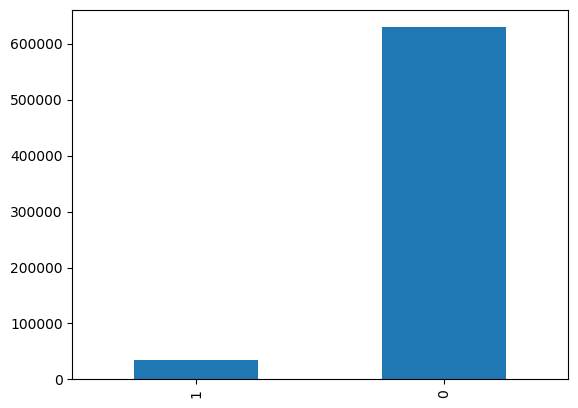

In [45]:
# target column
df["target"] = df["pre_diabetic_label"].map({"Yes":1,"No":0})
df["target"].value_counts().sort_values().plot(kind = 'bar')

In [46]:
def show_nans(table):
    '''
    Shows missing values count and percentage from highest to lowest
    '''
    nan_count = pd.DataFrame(table.isna().sum(), columns = ["actual_nan"])
    nan_count["percentage_missing"] = round(nan_count["actual_nan"]/table.shape[0],2)
    nan_count["column"] = nan_count.index
    nan_count.index = range(nan_count.shape[0])
    return nan_count.sort_values("percentage_missing",ascending=False)[["column","actual_nan","percentage_missing"]]

In [47]:
missing_df = show_nans(df)
missing_df[missing_df['percentage_missing']>0.0]

,column,actual_nan,percentage_missing
98,mapped_employment_status_code,143864,0.22
97,marital_status,16436,0.02


In [48]:
df.shape

(664581, 100)

In [49]:
# cols_to_drop = missing_df[missing_df['percentage_missing']>0.30].column

In [50]:
perc = 30.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df = df.dropna( axis=1, 
                thresh=min_count)

In [51]:
df.shape

(664581, 100)

In [52]:
# df.select_dtypes('int').columns

In [53]:
# cols=df.select_dtypes('object').columns
# for i in cols:
#     if df[i].isnull().sum() > 0:
#         print(i)
#         print(df[i].isnull().sum())

In [54]:
cols=df.select_dtypes('float').columns
df[cols].describe()

,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,age
count,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,664483.000000
mean,5.082627e+03,96.929494,251.935683,1.845274e+03,4.338416e+03,41.332363,259.505466,461.528433,3.340721e+03,74.974283,187.500887,1.265179e+03,2.772537e+03,29.524257,200.843026,356.032278,6.620541e+03,122.871271,324.471782,2.411579e+03,5.601637e+03,55.548854,328.782708,621.953401,47.155769
std,2.549875e+04,195.576988,962.035933,1.150908e+04,2.499800e+04,136.108667,751.761265,787.741076,1.815703e+04,208.412660,795.008803,8.434504e+03,1.764039e+04,114.405820,718.753962,771.891287,2.939056e+04,218.495252,1099.010136,1.408858e+04,2.881067e+04,155.406871,942.332594,925.609837,13.367262
min,-9.818706e+04,-688.597538,0.000000,-3.240900e+02,-1.004371e+05,-250.000000,-5034.520000,-9494.720000,-1.064651e+05,-11018.395000,0.000000,-8.129090e+03,-1.060451e+05,-1140.000000,-46458.230000,-12633.880000,-1.379117e+05,-15323.518889,0.000000,-1.027400e+02,-1.370656e+05,-400.000000,-5786.460000,-8884.410000,1.000000
25%,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,4.160500e+02,41.787000,43.704717,1.414800e+02,2.045300e+02,0.000000,0.000000,0.000000,36.000000
50%,6.808000e+02,53.541429,55.154329,1.784300e+02,3.396300e+02,0.000000,0.000000,121.600000,1.639300e+02,26.228750,23.582896,9.451000e+01,0.000000e+00,0.000000,0.000000,0.000000,1.239020e+03,68.896386,75.393372,2.555700e+02,6.886700e+02,0.000000,0.000000,289.620000,47.000000
75%,2.631180e+03,104.385000,133.686071,5.823000e+02,1.635240e+03,0.000000,80.080000,591.330000,1.408710e+03,80.466111,90.046551,3.125900e+02,7.191300e+02,0.000000,14.460000,381.570000,3.937700e+03,125.054000,200.057659,9.453100e+02,2.607830e+03,30.000000,171.970000,800.000000,58.000000
max,2.636617e+06,16115.461667,185127.707935,2.421475e+06,2.632617e+06,12146.570000,84841.060000,28917.340000,2.313374e+06,36086.847500,99500.841376,1.865211e+06,2.309874e+06,3275.920000,143267.510000,28117.030000,3.219357e+06,24394.582500,110551.046644,2.366361e+06,3.211107e+06,4279.600000,193418.870000,18623.100000,222.000000


In [55]:
# cols=df.select_dtypes(['float','int']).columns
# for i in cols:
#     if df[i].isnull().sum() > 0:
#         print(i)
#         print(df[i].isnull().sum())

In [56]:
def cat_vs_cat_plot(predictor):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    df.groupby(predictor, observed=True, dropna=False, sort=False)['person_internal_id'].count().plot(kind='bar',stacked=True,color='skyblue',legend=False,ax=axes[0])
    #df[predictor].value_counts(sort=False).plot(kind='bar',ax=axes[0])
    df.groupby(predictor, observed=True, dropna=False, sort=False)['pre_diabetic_label'].value_counts(normalize=True).unstack().plot(kind='bar',stacked=True,ax=axes[1])
    plt.show()

In [57]:
def cat_vs_count_plot(predictor):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    sns.boxplot(data=df, x=predictor, y='pre_diabetic_label', orient='h', ax=axes[0])
    sns.kdeplot(df[df['pre_diabetic_label']=='No'][predictor], shade=True, label=0, ax=axes[1],bw=0.3)
    sns.kdeplot(df[df['pre_diabetic_label']=='Yes'][predictor], shade=True, label=1, ax=axes[1],bw=0.3)
    plt.title(f'Count of NULL values in {predictor}: {df[predictor].isna().sum()}')
    plt.show()

Data cleaning: columns are having mutiple entries for a same text, hence reducing them to individual entries:

In [58]:
Divorce_list = ['Divorced', 'Divorced_United_States_of_America', 'Separated_United_States_of_America', \
                           'Divorced_USA', 'USA_Divorced', 'USA_Separated', 'Separated_USA', 'Separated USA', 'Divorced USA', \
                           'Legally_Separated_United_States_of_America', 'USA-Divorced', 'Widowed_United_States_of_America', 'USA-Separated','Widowed_USA','PR_Divorced']
Single_list = ['S', 'Single', 'Single_United_States_of_America', 'Single_USA', 'USA-Single', 'USA_Single', 'Single USA',\
                                           'S-USA', 'USA-Single, PR_Single', 'PR_Single']   
Unknown_list = ['unknown','Unknown_USA', 'Unknown_United_States_of_America', 'Not_Indicated_United_States_of_America', \
                  'PR_Living Together','USA_Living together','USA_Not Disclosed', 'USA_Not Disclosed','Living_Together_United_States_of_America',
                'Domestic_Partner _United_States_America', 'Civil P_United_States_of_America']
Married_list = ['M','Married_United_States_of_America','Married_USA','Married USA','Married','M_USA','M-USA','USA-Married','USA_Married','Married_USA','Maried','USA-Married/ Civil Partnership','Domestic_Partner_United_States_of_America','Partnered_United_States_of_America','Co-Habiting_United_States_of_America','Partnered USA','D-USA']
values = ['Single_Canada','Single_MEX', 'Single_DEU','Head_of_Household_USA','DE_FACTO','O-USA','MI_NOT_DISCLOSED','Domestic Partner', 'MARITAL_STATUS-3-321', 'Single_COL', 'PR_Partnered','Divorced_United_Kingdom','Single_MEX','MARITAL_STATUS-6-321','Unknown_United_States_of_America','Not_Indicated_United_States_of_America','Not_Disclosed_United_States_of_America','IN_Single',
          'Unknown_USA','MARITAL_STATUS-3-321','Married_MEX', 'S-HKG',
       'Unknown_New_Zealand', 'Unknown_Korea_Republic_of',
       'Married_Saudi_Arabia', 'Single_United Kingdom', 'Single_Thailand',
       'Unknown_United Kingdom', 'Unknown_India', 'Married_Taiwan',
       'Single_Taiwan', 'Single_Hong_Kong', 'Single_Korea_Republic_of', 'P-USA', 'Married_BRA', 'Married_DEU',
       'Unknown_SWE','Single_DOM',
       'Married_CHN', 'Married_ESP', 'Single_THA',
       'Married_Kenya', 'Unknown_Taiwan', 'Married_China',
       'Married_New_Zealand', 'Single0_Indonesia', 'Single_Spain',
       'Unknown_Thailand', 'Unknown_Spain', 'Married_Malaysia',
       'Married2_Indonesia', 'Married_Thailand','MARITAL_STATUS-3-40', 'Married_United_Kingdom',
       'Unknown_Puerto Rico','Single_United Arab Emirates', 'Divorced_Hong_Kong',
       'Civil_Partnership_MEX', 'Married_SGP', 'Unknown_AUS',
        'Single_SGP', 'Married_Spain',
       'Divorced_Singapore', 'Divorced_Canada', 'Married_Italy',
       'Married_MEX', 'Married_AUS', 'Single_ESP', 'Unknown_JPN',
       'PR_Married', 'M-GBR', 'Married_Switzerland', 'Domestic Partner',
       'W-USA', 'DE_FACTO', 'PR_Widowed', 'MI_NOT_DISCLOSED',
       'Married_CAN', 'Divorced_DEU', 'Dissolved_Civil_Partnership_MEX',
       'Single_FRA', 'Single_COL', 'Single_Puerto Rico', 'MARITAL_STATUS-6-301', 'MARITAL_STATUS-6-322', 'Hd Hsehld_United_States_of_America',
       'Common_Law_United_States_of_America', 'Married_Ireland',
       'Common_law_Canada', 'Married_Canada','Domestic_Partner_Canada',
       'U-USA','MARITAL_STATUS-3-323', 'USA-Cohabit', 'Married0_Indonesia', 'Married_Korea_Republic_of', 'Single_China',
       'Married1_Indonesia', 'Single_CAN', 'Married_SWE',
       'Single_Belgium', 'Married_United Kingdom', 'Married_Puerto Rico',
       'Married_ITA', 'Single_BEL', 'Married_BEL', 'Single_Lebanon',
       'Unknown_Kenya', 'M-DEU', 'Unknown_GBR', 'Civil Partner_Belgium',
       'Married_IRL', 'USA-Civil Partnership', 'Married_Hong_Kong',
       'Domestic Partner Civil Union_United Kingdom',
       'Civil_Partnership_COL', 'Unknown_Canada', 'Civil_Partnership_USA',
       'Single_JPN', 'Married_MYS', 'Single_IRL', 'Single_New_Zealand',
       'Married_Belgium', 'Civil_Partnership_United_States_of_America',
       'Married_COL', 'Common_Law_COL', 'Married_Austria', 'Single_GBR',
       'Married_GBR', 'Single_SWE', 'Married_JPN', 'Unknown_MLT',
       'Married_NZL', 'Unknown_CHN', 'PR_Not Disclosed', 'R-USA', 'RDP',
       'S-GBR', 'Married_Puerto_Rico', 'Married_Singapore', 'S-CHN',
       'Married_United Arab Emirates', 'M-SGP', 'Single_Singapore',
       'Separated_MLT', 'USA_Common-law', 'C-USA', 'S-ARE', 'S-SGP',
       'Single_CHN', 'Single_United_Kingdom', 'M-CAN', 'M-IND',
       'Single_BRA', 'Divorced_ESP', 'M-AUS', 'USA-Widowed',
       'PRI-Married', 'Single_Argentina', 'Unspecified_United_Kingdom',
       'Domestic_Partnered_United_States_of_America',
       'Co-Habiting_United_Kingdom', 'Married_Turkey',
       'Registered_Partnership_United_States_of_America',
       'Unknown_Malaysia', 'USA-Unknown', 'USA_Widowed', 'M-HKG','Single_United_States_of_America_Germany',
        'Single _United_States_of_America_Japan','Married_United_States_of_America_Germany','Married _United_States_of_America_Korea',
         'Common_Law_USA','Domesitc Partnership_USA','Married_United_States_of_America_Japan','Single _United_States_of_America_Korea',
         'MARITAL_STATUS-3-69', 'Domestic Partner_United_States_of_America', 'Single_Philippines', 'Divorced_United_States_of_America_Japan',
         'Single _United_States_of_America_United Kingdom','Head_of_Household_United_States_of_America','Not_Indicated_United_States_of_America_Germany',
         'Not_Indicated_United_States_of_America_Panama','Not Provided','USA_Partnered','USA_Married/Civil Partnership',
         'Married _United_States_of_America_Italy']

In [59]:
df.loc[df['marital_status'].isin(Divorce_list), 'marital_status'] = 'Divorced'
df.loc[df['marital_status'].isin(Single_list), 'marital_status'] = 'Single'
df.loc[df['marital_status'].isin(Married_list), 'marital_status'] = 'Married'
df.loc[df['marital_status'].isin(Unknown_list), 'marital_status'] = 'Unknown'
df.loc[df['marital_status'].isnull(), 'marital_status'] = 'Unknown'

In [60]:
df = df[df.marital_status.isin(values) == False]

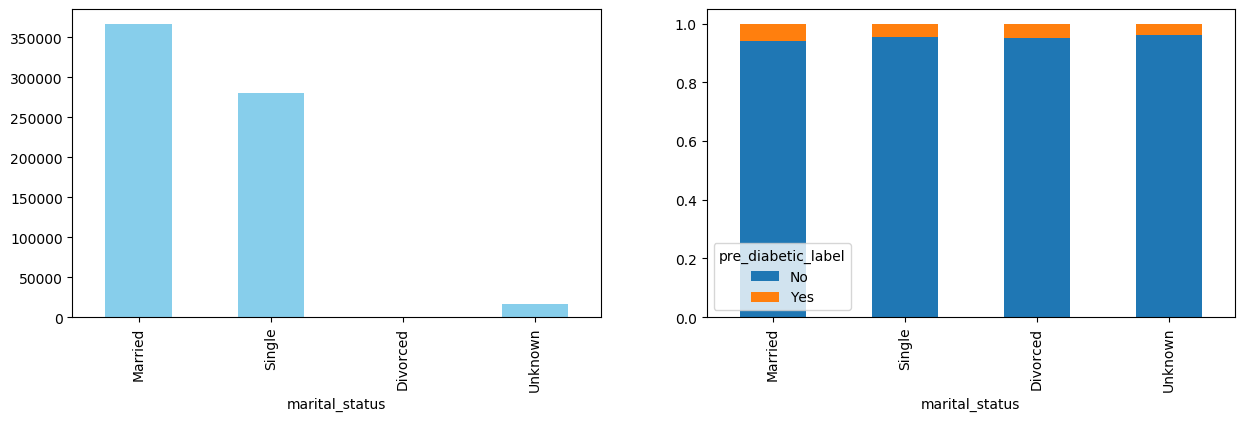

In [61]:
cat_vs_cat_plot('marital_status')

In [62]:
df.marital_status.value_counts()

Married     367212
Single      280830
Unknown      16443
Divorced        84
Name: marital_status, dtype: int64

In [63]:
active_list = ['ACTIVE','Active','Disability - Long Term or Perm','Disability - Short Term','LOA - Family Medical',
               'LOA - Military','LOA - no Pay','LOA - with Pay',"LOA - Worker's Compensation",'LOFF','LOA_NO_PAY',
              'LOA_FM', 'LOA_WITH_PAY','LTD','STD','LOA_WC','LOA_MLTR','LOA - Unpaid w/ Benefits','LOA - Paid Leave',
              'LOA - Unpaid Leave','LOA - STD','LOA - LTD','LOA - Workers Comp']
inactive_list = ['Inactive','COBRA Employee','Deceased - In Service','Deceased - Out-of-Service','Layoff','Retired',
                 'Severance Pay','Termination','RTEE','SVRN_PAY','DCSD_OUT_OF_SV','DCSD_INSV','COBRA_EE',
                'Terminated',]
non_employee_list = ['COBRA Dependent','Enrolled Beneficiary','Enrolled QDRO', 'ENRL_BENE','COBRA_DPND','ENRL_QDRO' ]
code_remove_list = ['DNM']

In [64]:
df.loc[df['mapped_employment_status_code'].isin(active_list), 'mapped_employment_status_code'] = 'Active'
df.loc[df['mapped_employment_status_code'].isin(inactive_list), 'mapped_employment_status_code'] = 'Inactive'
df.loc[df['mapped_employment_status_code'].isin(non_employee_list), 'mapped_employment_status_code'] = 'Non-Employee'
df.loc[df['mapped_employment_status_code'].isin(code_remove_list) == False]
df.loc[df['mapped_employment_status_code'].isnull(), 'mapped_employment_status_code'] = 'Unknown'

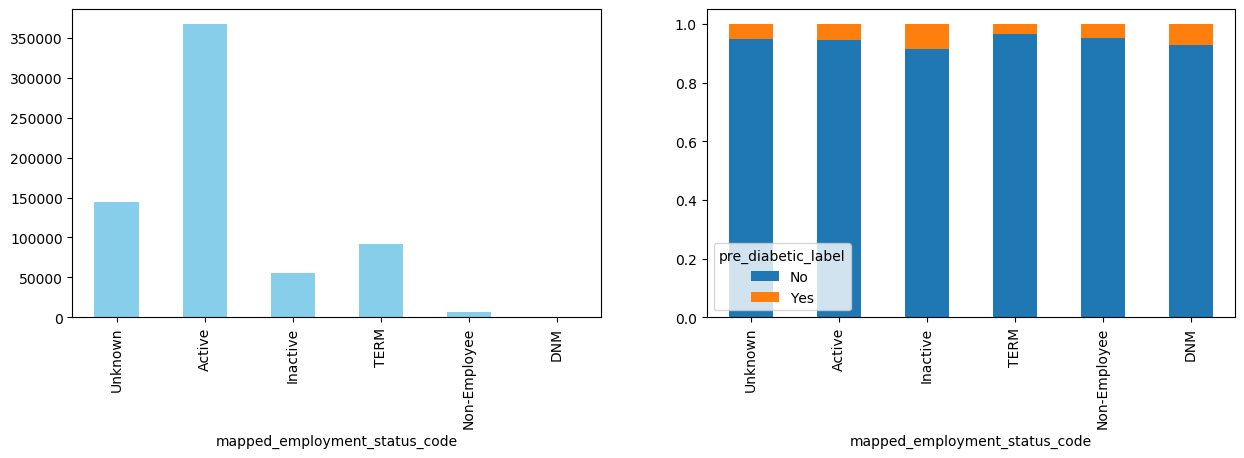

In [65]:
cat_vs_cat_plot('mapped_employment_status_code')

In [66]:
df.mapped_employment_status_code.value_counts()

Active          367400
Unknown         143859
TERM             91778
Inactive         55214
Non-Employee      6277
DNM                 41
Name: mapped_employment_status_code, dtype: int64

In [67]:
male = ['M', 'Male', 'male', 'Gender_Male']
female = ['F', 'Female', 'female', 'Gender_Female']
unknown = ['U', 'Unknown', 'Not_declared', 'D', 'Decline to answer', 'Undeclared',
           'Not specified', 'Declined to State','ND', 'N', 'O', 'Not Declared','X',
           'I do not wish to provide this information','Not declared','I Choose not to Disclose']

In [68]:
df.loc[df['gender'].isin(male), 'gender'] = 'Male'
df.loc[df['gender'].isin(female), 'gender'] = 'Female'
df.loc[df['gender'].isin(unknown), 'gender'] = 'Unknown'
df.loc[df['gender'].isnull(), 'gender'] = 'Unknown'

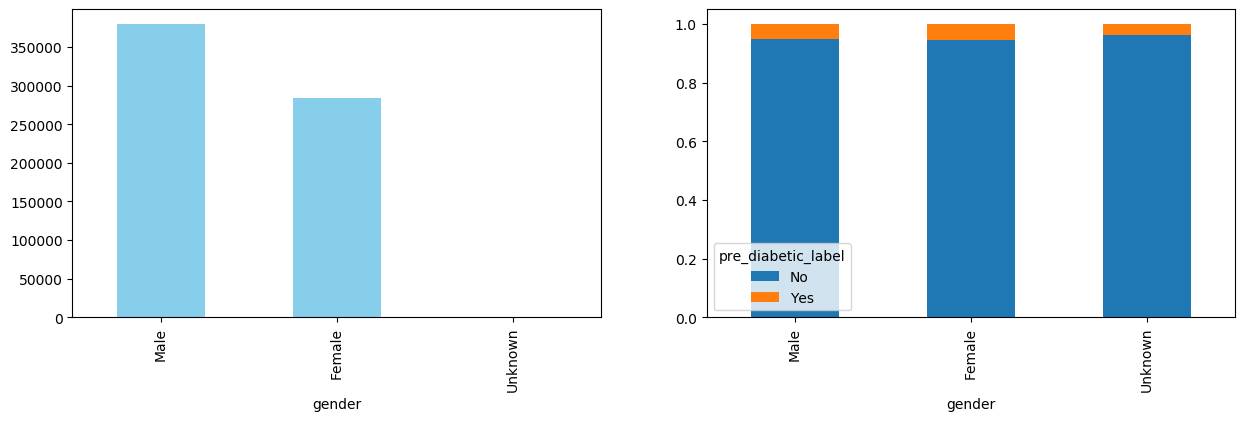

In [69]:
cat_vs_cat_plot('gender')

In [70]:
df.gender.value_counts()

Male       380124
Female     284009
Unknown       436
Name: gender, dtype: int64

In [71]:
# df['mapped_flex_status_code'] = df['mapped_flex_status_code'].replace(['NOTELIGIBLE','ELIGIBLE'],['Not-Eligible', 'Eligible'])
# flex_code_remove_list = ['DNM', 'INELIG', 'HIITSD', 'NGACT',
#        'TSDACT', 'ACTIVE', 'LOALIF', 'NNSACT', 'ACTHER', 'RET', 'COBTSD',
#        'ACTF', 'EXACT', 'SEVTSD']
# df = df[df['mapped_flex_status_code'].isin(flex_code_remove_list) == False]
# df.loc[df['mapped_flex_status_code'].isnull(), 'mapped_flex_status_code'] = 'Unknown'

In [72]:
# cat_vs_cat_plot('mapped_flex_status_code')

In [73]:
# df.mapped_flex_status_code.value_counts()

In [74]:
# df['base_pay_regular_frequency_code'] = df['base_pay_regular_frequency_code'].replace(['A1','H1','M1','W1','W2'],['Annual','Hourly','Monthly','Weekly','Weekly'])
# pay_code_remove_list = ['1','2','3','4']
# df = df[df['base_pay_regular_frequency_code'].isin(pay_code_remove_list) == False]
# df.loc[df['base_pay_regular_frequency_code'].isnull(), 'base_pay_regular_frequency_code'] = 'Unknown'

In [75]:
# cat_vs_cat_plot('base_pay_regular_frequency_code')

In [76]:
# df.base_pay_regular_frequency_code.value_counts()

Box-Plot and KDE for numeric data type-

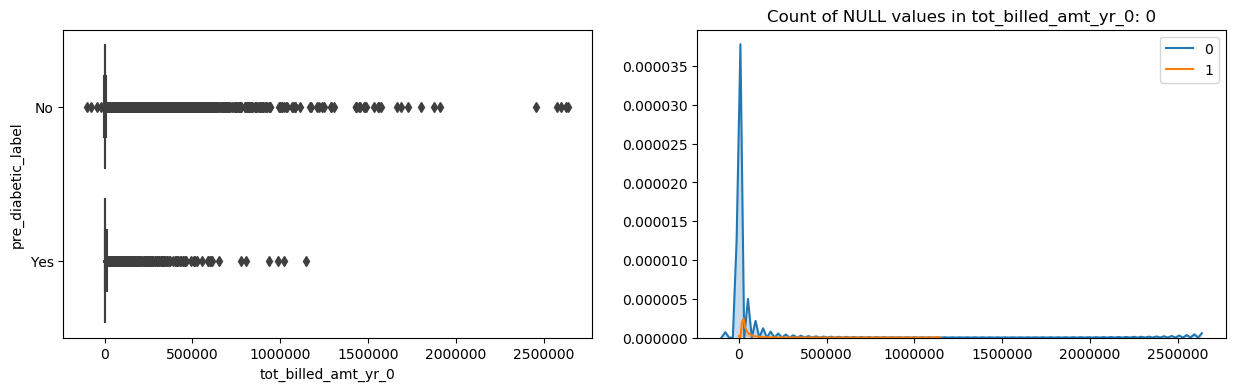

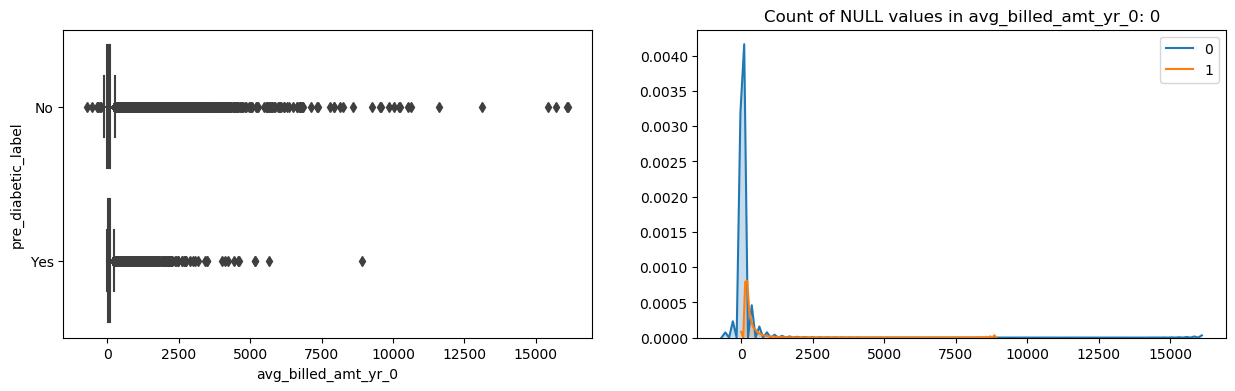

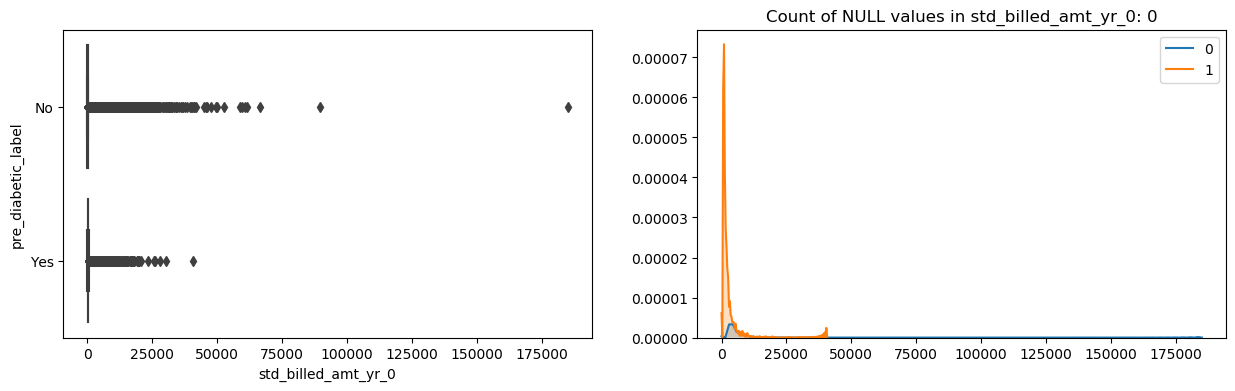

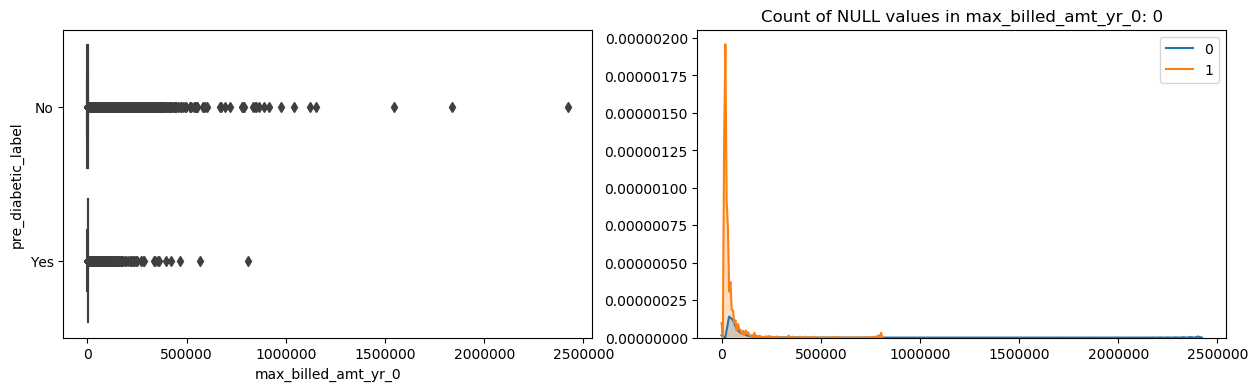

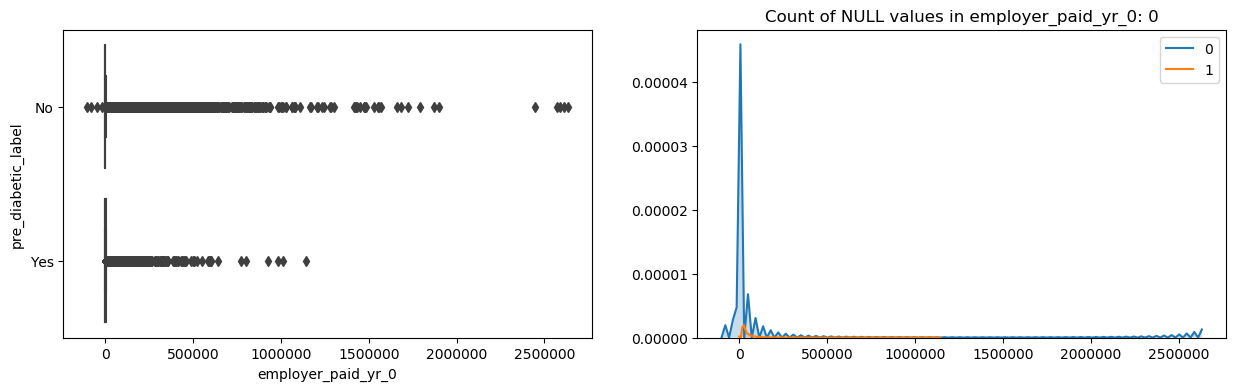

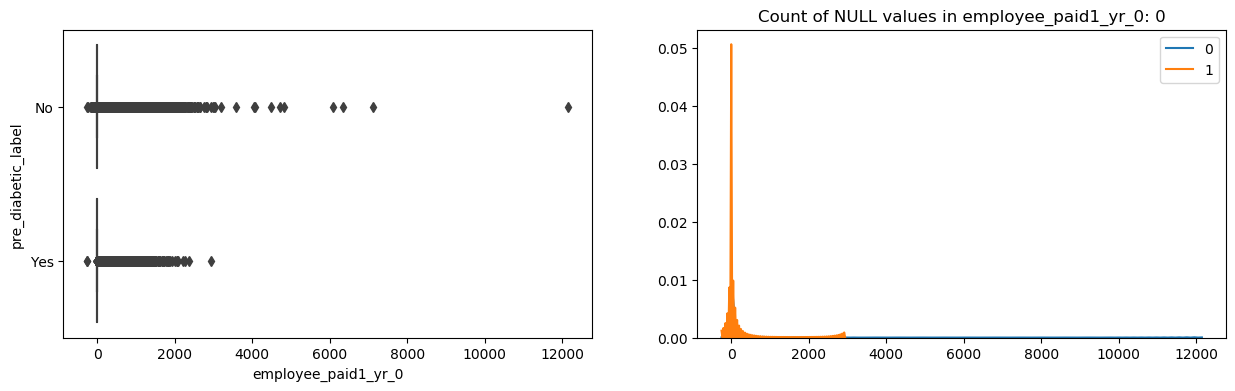

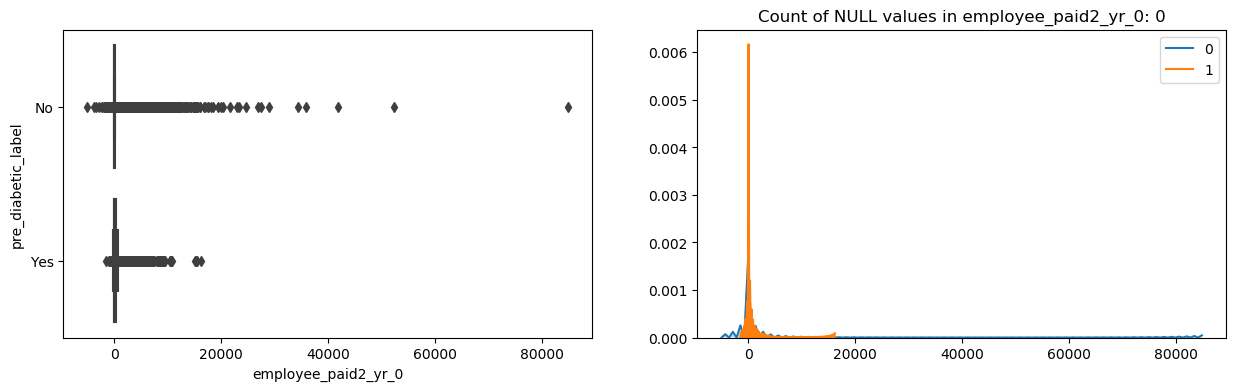

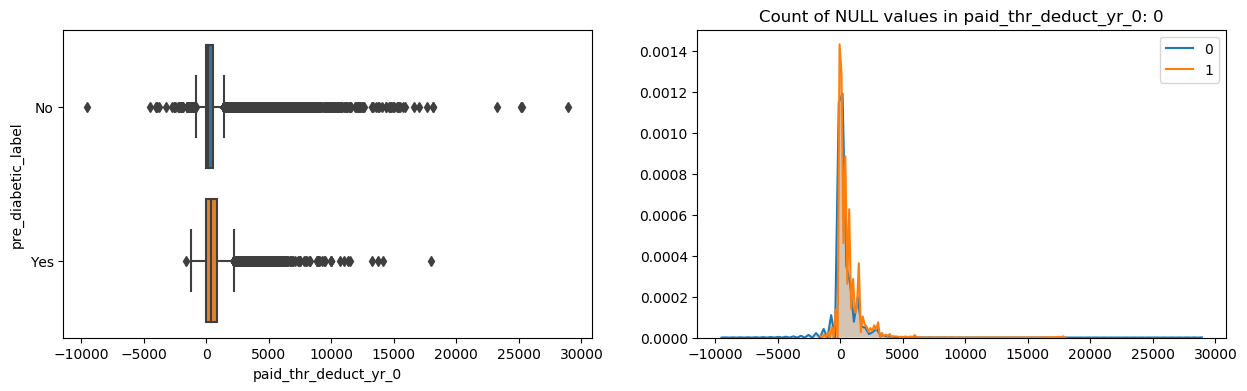

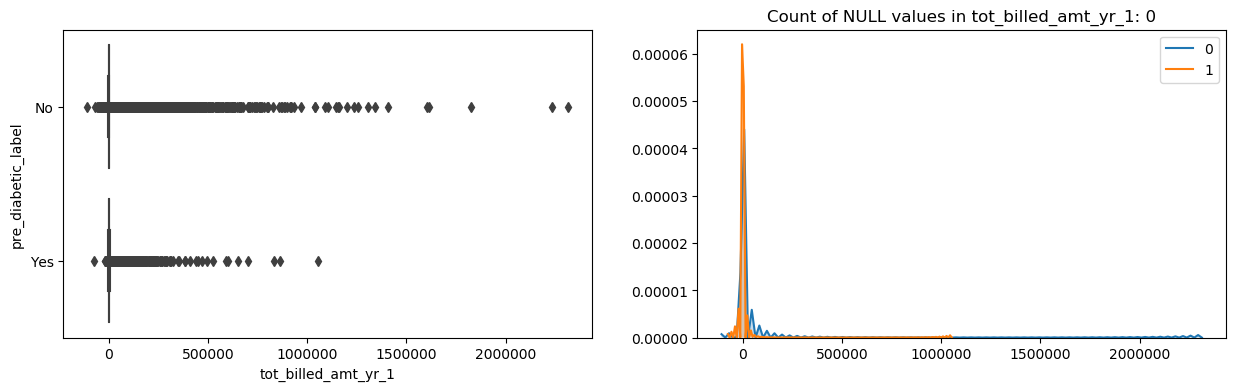

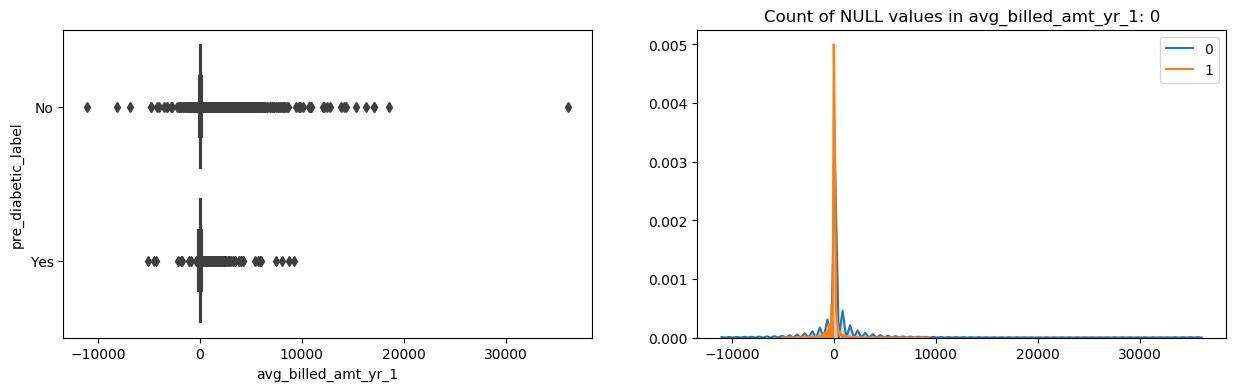

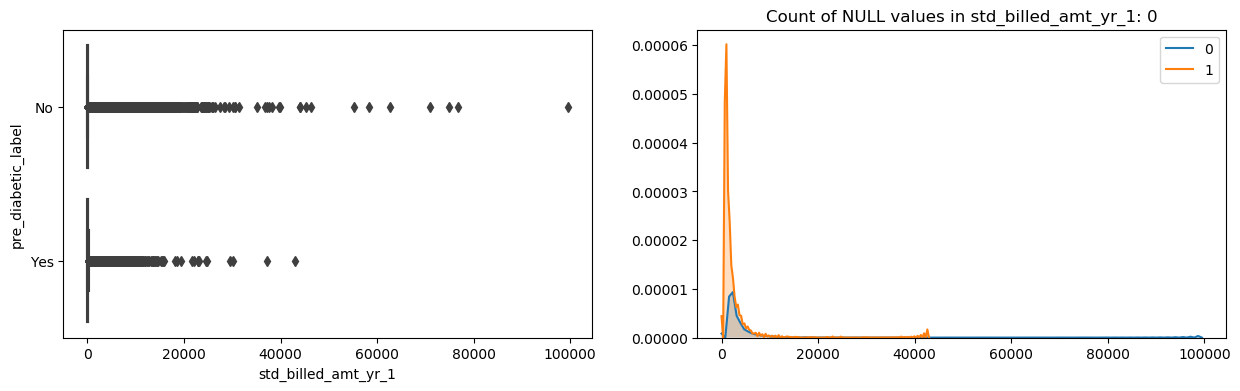

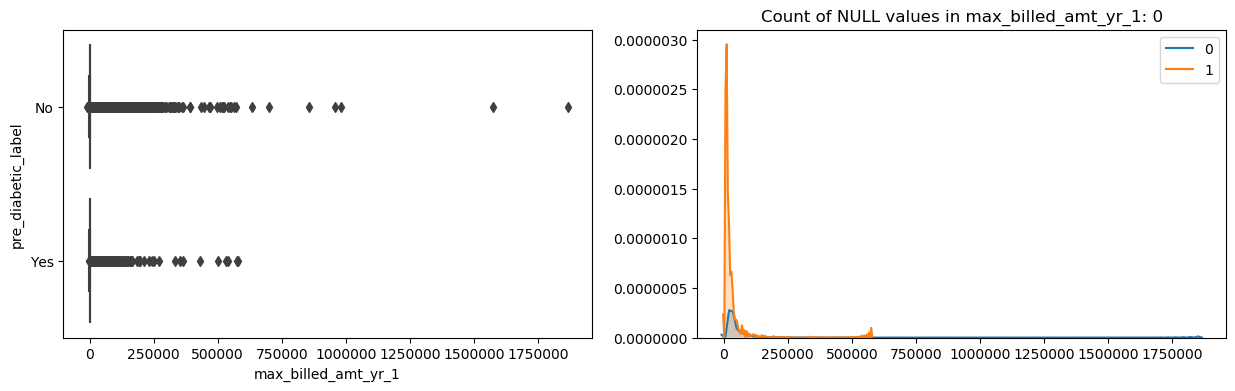

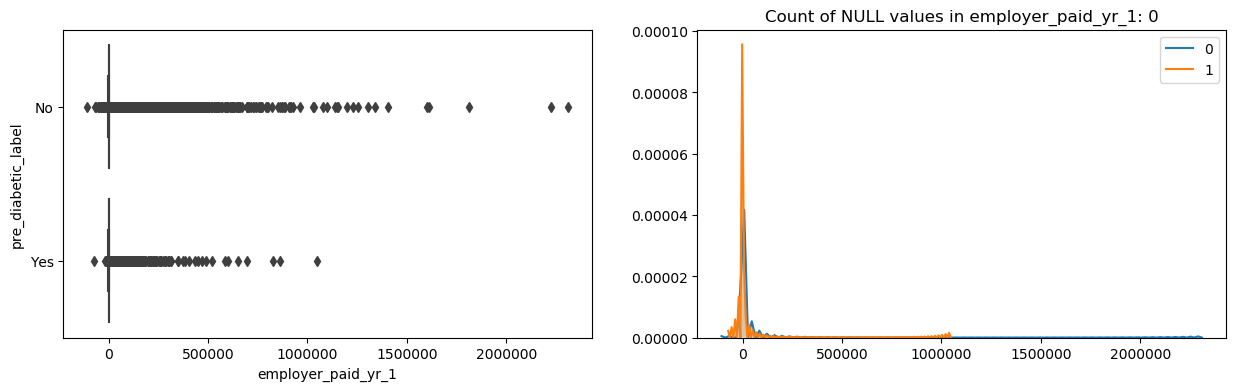

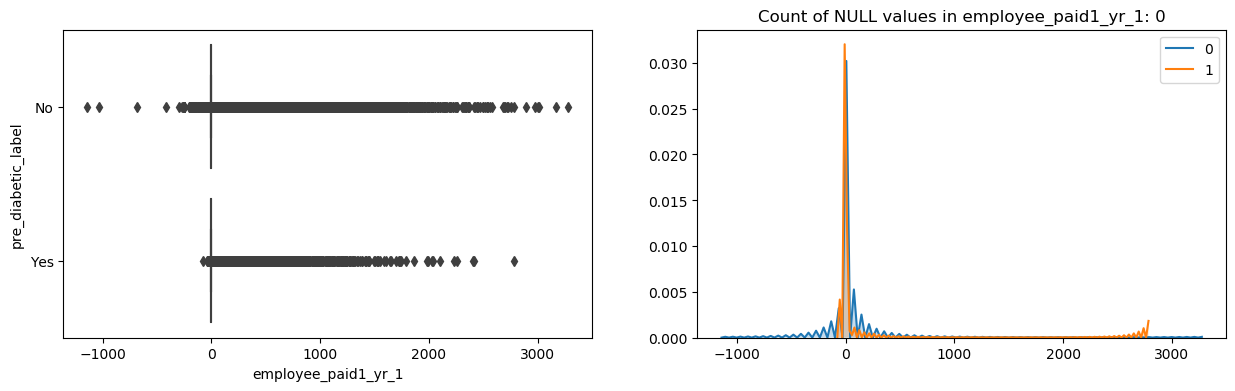

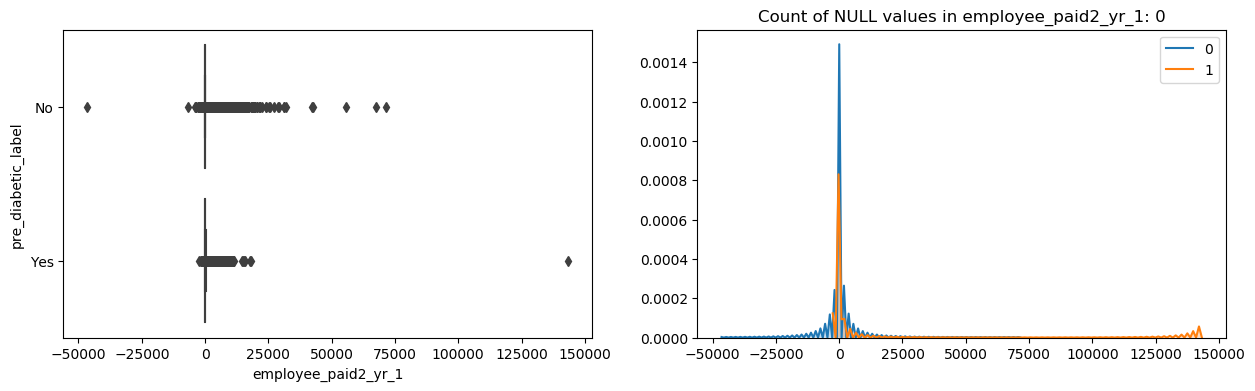

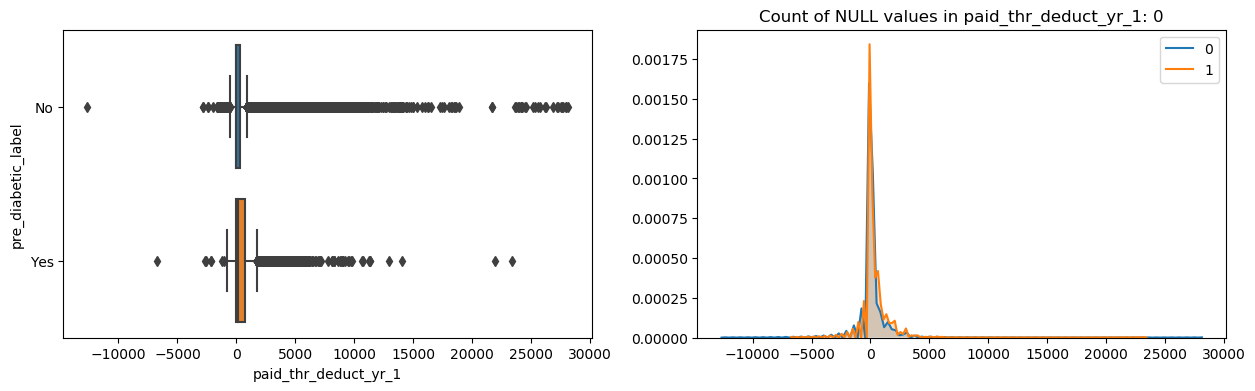

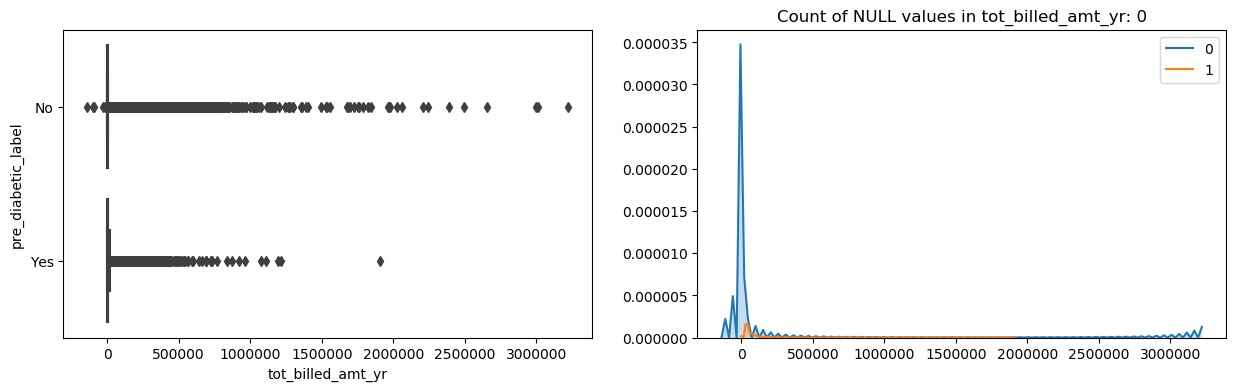

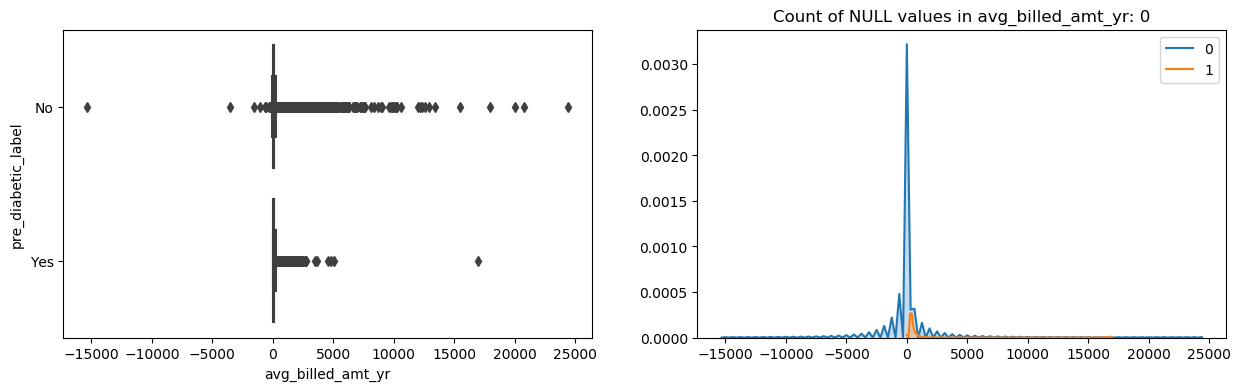

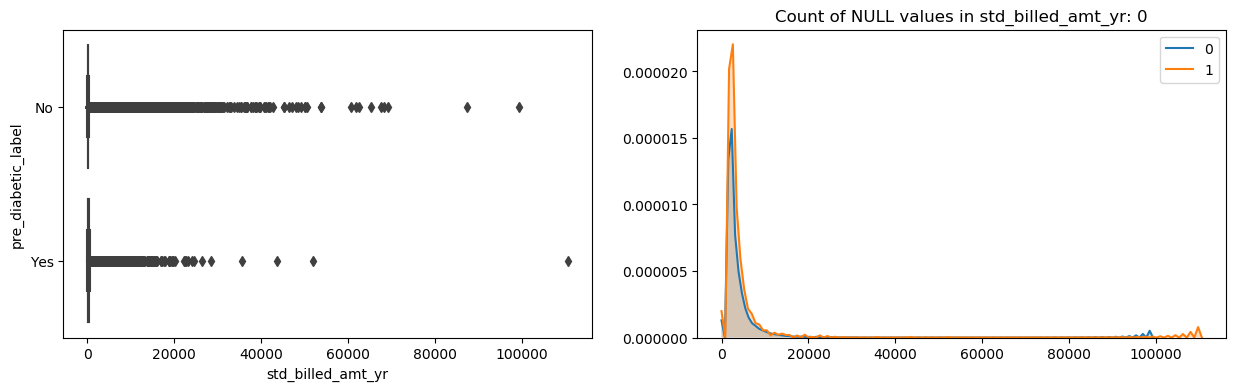

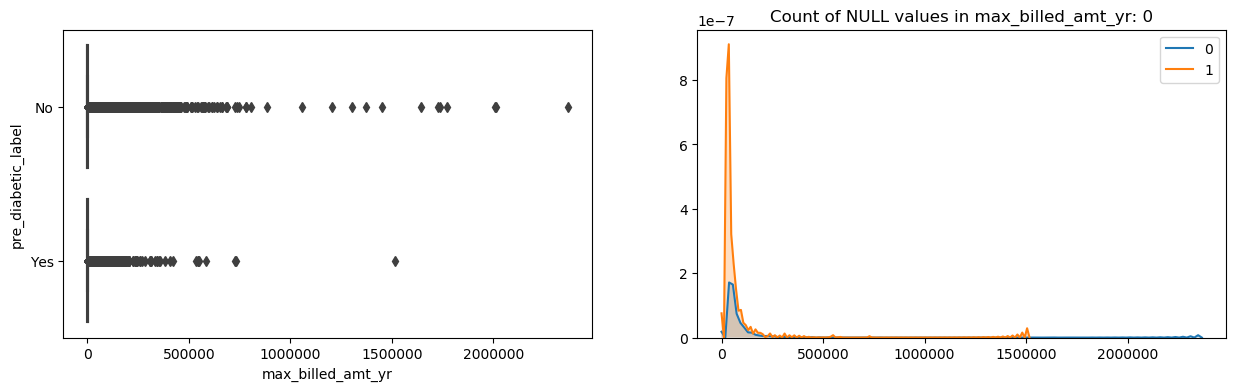

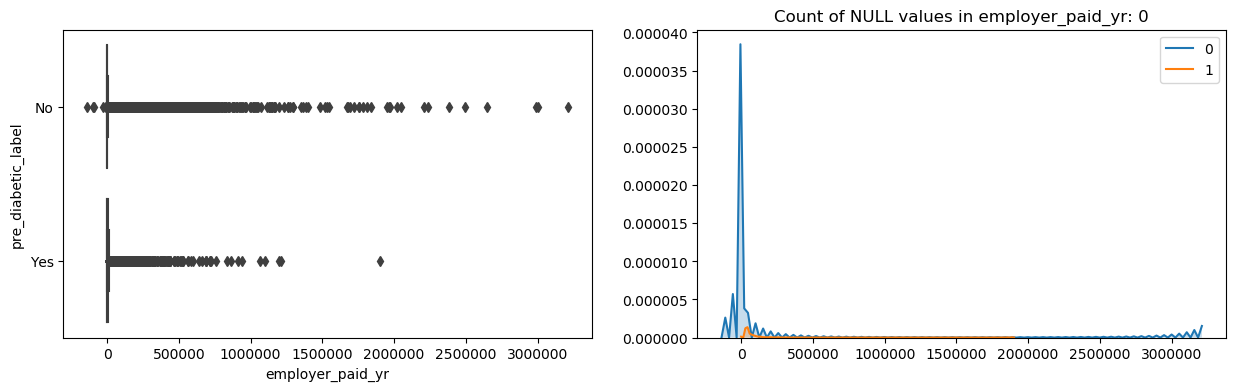

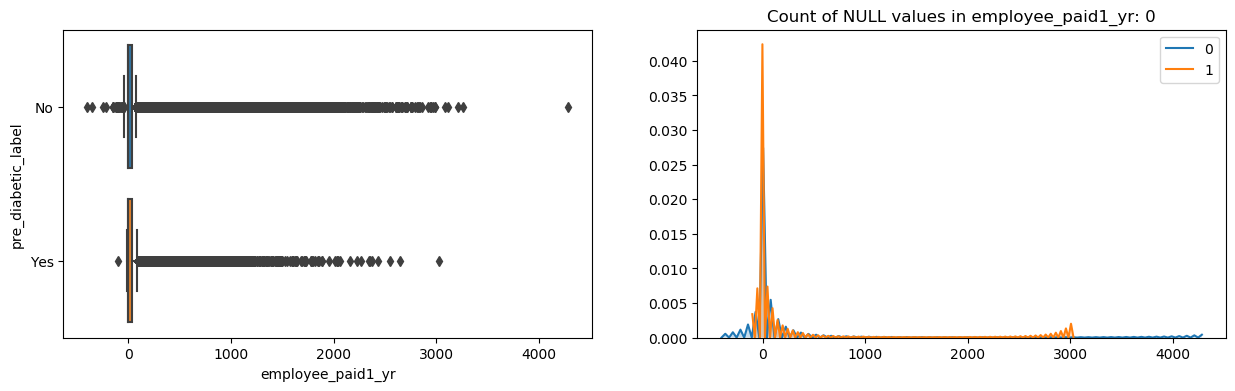

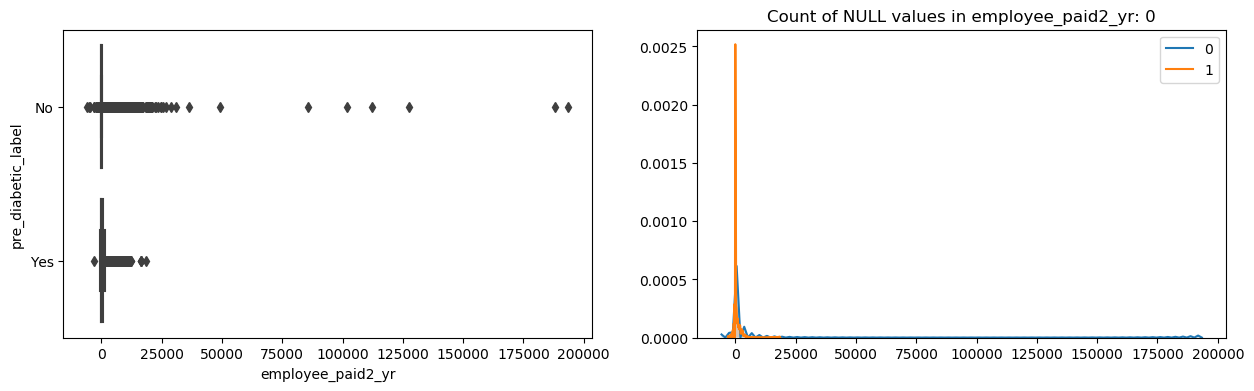

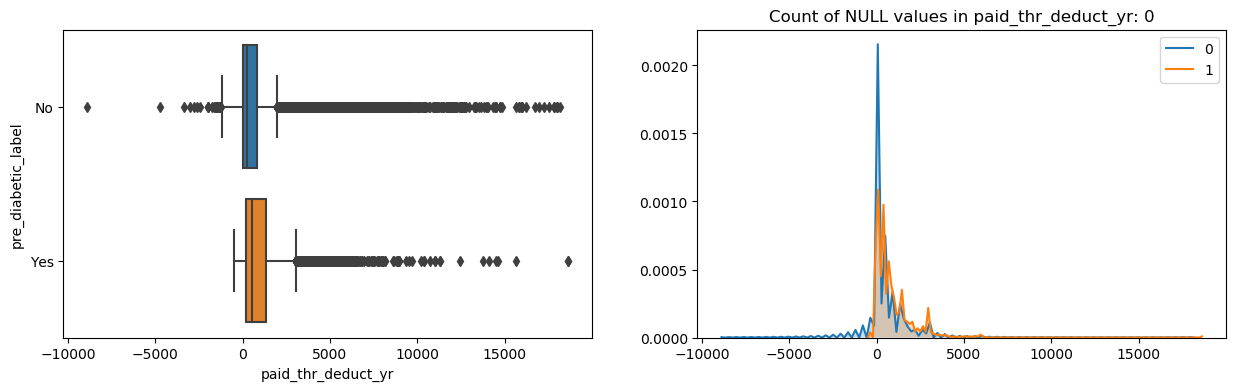

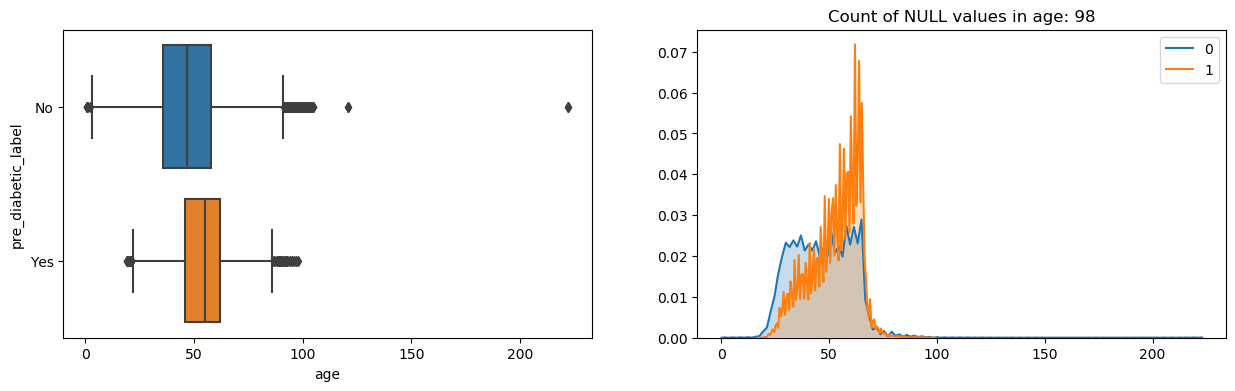

In [77]:
for i in (df.select_dtypes('float').columns):
    cat_vs_count_plot(i)

next step is to check multi-collinearity among predictors
using highly correlated features (among predictors) is not good for regression models. However, for treee based model
it is fine to use them, there is no impact.
Focus of this activity is to identify highly correlated features, and drop only variables having pearson correlation
equals to +- 1 (since mostly we will be using tree based algorithms only)

In [78]:
corr = df.corr().abs()

In [79]:
# setting diagonal entries as zero (from one) -- this to idenitfy highest correlation score for each feature
corr = corr.where(corr.values != np.diag(corr),0,corr.where(corr.values != np.flipud(corr).diagonal(0),0,inplace=True))

In [80]:
mult_corr_df = corr.max().round(3).sort_values(ascending=False).reset_index()
mult_corr_df.shape

(29, 2)

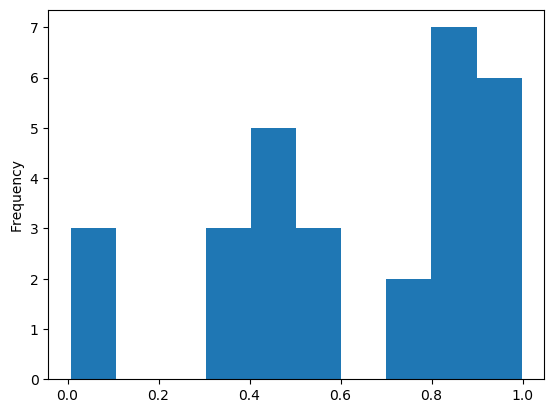

In [81]:
mult_corr_df[0].plot(kind='hist')

In [82]:
mult_corr_df.head(10)

,index,0
0,employer_paid_yr,0.998
1,tot_billed_amt_yr,0.998
2,tot_billed_amt_yr_0,0.997
3,employer_paid_yr_0,0.997
4,employer_paid_yr_1,0.996
5,tot_billed_amt_yr_1,0.996
6,std_billed_amt_yr_0,0.884
7,max_billed_amt_yr_0,0.884
8,max_billed_amt_yr,0.861
9,std_billed_amt_yr,0.861


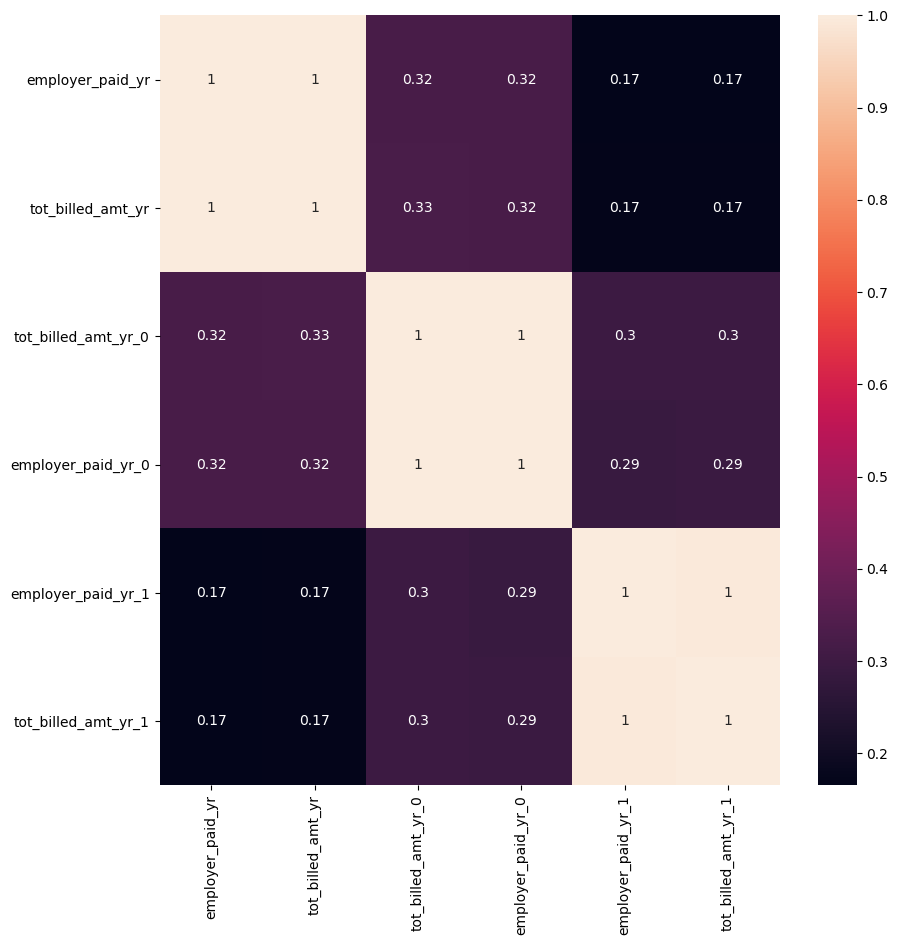

In [83]:
# let us look correlation matrix of variables with above score > 0.99
plt.figure(figsize=(10,10))
sns.heatmap(df[mult_corr_df[mult_corr_df[0]>0.99]['index'].tolist()].corr(), annot=True)
plt.show()

As we can observe that below groups are highly corelated
- Group1- annual_benefits_base_rate, base_pay_regular_expectedannualsalary, base_pay_regular_payrate_amount
- Group2- tot_billed_amt_yr_0, employer_paid_yr_0
- Group3- tot_billed_amt_yr_1, employer_paid_yr_1
- Group4- tot_billed_amt_yr, employer_paid_yr

we can consider only one variable from each group

In [84]:
mult_corr_list = mult_corr_df[mult_corr_df[0]>0.99]['index'].tolist()
mult_corr_list.append('target')
df[mult_corr_list].corr()['target'].sort_values(ascending=False)

target                 1.000000
tot_billed_amt_yr      0.034486
employer_paid_yr       0.030806
tot_billed_amt_yr_1    0.021441
tot_billed_amt_yr_0    0.018064
employer_paid_yr_1     0.018042
employer_paid_yr_0     0.015293
Name: target, dtype: float64

In [85]:
# df.corr()['target'].sort_values(ascending=False)

In [86]:
# we can keep tot_billed_amt_yr_0, tot_billed_amt_yr_1 as these are highly correlated to
#keeping  base_pay_regular_expectedannualsalary as well
# target as compared to other variables
# drop_list = ['tot_billed_amt_yr_1','tot_billed_amt_yr_0','tot_billed_amt_yr']

In [87]:
# other vaiable we can drop which are not highly correlated with target variable to reduce dimentionalty of dataset

In [88]:
corr_with_target_df = corr['target'].abs().sort_values().round(3).reset_index()
corr_with_target_df.shape

(29, 2)

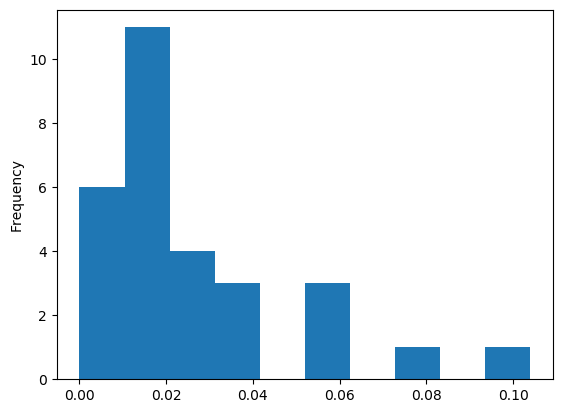

In [89]:
corr_with_target_df['target'].plot(kind='hist')

In [90]:
# variables which have less than 5% correlation with target variable
cor_df = corr_with_target_df[corr_with_target_df['target']<0.1]

In [91]:
cols_to_drop_1 = cor_df['index']

In [92]:
cols_to_drop_1

0       person_internal_id
1                   target
2        avg_billed_amt_yr
3      employee_paid1_yr_1
4      employee_paid1_yr_0
5              patient_key
6      avg_billed_amt_yr_0
7        employee_paid1_yr
8      max_billed_amt_yr_0
9       employer_paid_yr_0
10     std_billed_amt_yr_0
11     avg_billed_amt_yr_1
12               client_id
13      employer_paid_yr_1
14     tot_billed_amt_yr_0
15     max_billed_amt_yr_1
16     std_billed_amt_yr_1
17     tot_billed_amt_yr_1
18       std_billed_amt_yr
19       max_billed_amt_yr
20        employer_paid_yr
21       tot_billed_amt_yr
22     employee_paid2_yr_0
23     employee_paid2_yr_1
24    paid_thr_deduct_yr_1
25       employee_paid2_yr
26    paid_thr_deduct_yr_0
27      paid_thr_deduct_yr
Name: index, dtype: object

In [93]:
#Drop unneccesray columns
drop_list = ['client_id','person_internal_id','patient_key','pre_diabetic_label','client_pid']

In [94]:
drop_list.extend(cols_to_drop_1)

In [95]:
drop_list.remove('target')

In [96]:
# drop_list

In [97]:
df.drop(columns = drop_list, axis=1,inplace=True)

In [98]:
df.shape

(664569, 71)

In [99]:
num_cols = [x for x in df.columns if ('amt' in x or 'paid' in x)] + ['age']

In [100]:
len(num_cols)

1

In [101]:
df[[x for x in df.columns if x not in num_cols]].head(2)

,preventive_visit_flag_yr_0,blood_glucose_test_flag_yr_0,hypertension_flag_yr_0,obesity_flag_yr_0,family_history_diabetes_flag_yr_0,physical_excercise_flag_yr_0,dietary_counselling_flag_yr_0,screening_diabetes_mellitus_flag_yr_0,sleep_apnea_flag_yr_0,cushing_syndrome_flag_yr_0,acromegaly_flag_yr_0,polyuria_flag_yr_0,nocturia_flag_yr_0,polydipsia_flag_yr_0,ovarian_disorder_flag_yr_0,heart_disorder_flag_yr_0,preventive_visit_flag_yr_1,blood_glucose_test_flag_yr_1,hypertension_flag_yr_1,obesity_flag_yr_1,family_history_diabetes_flag_yr_1,physical_excercise_flag_yr_1,dietary_counselling_flag_yr_1,screening_diabetes_mellitus_flag_yr_1,sleep_apnea_flag_yr_1,cushing_syndrome_flag_yr_1,acromegaly_flag_yr_1,polyuria_flag_yr_1,nocturia_flag_yr_1,polydipsia_flag_yr_1,ovarian_disorder_flag_yr_1,heart_disorder_flag_yr_1,preventive_visit_flag_yr,blood_glucose_test_flag_yr,hypertension_flag_yr,obesity_flag_yr,family_history_diabetes_flag_yr,physical_excercise_flag_yr,dietary_counselling_flag_yr,screening_diabetes_mellitus_flag_yr,sleep_apnea_flag_yr,cushing_syndrome_flag_yr,acromegaly_flag_yr,polyuria_flag_yr,nocturia_flag_yr,polydipsia_flag_yr,ovarian_disorder_flag_yr,heart_disorder_flag_yr,specialist_ind,primary_care_ind,physician_ind,unknown_ind,durable_medical_ind,lab_visit_ind,specialist_ind_y0,primary_care_ind_y0,physician_ind_y0,unknown_ind_y0,durable_medical_ind_y0,lab_visit_ind_y0,specialist_ind_y1,primary_care_ind_y1,physician_ind_y18,unknown_ind_y1,durable_medical_ind_y1,lab_visit_ind_y1,gender,marital_status,mapped_employment_status_code,target
0,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,Male,Married,Unknown,0
1,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,No,No,No,Yes,Male,Single,Unknown,0


In [102]:
df[num_cols].describe().round(0)

,age
count,664471.0
mean,47.0
std,13.0
min,1.0
25%,36.0
50%,47.0
75%,58.0
max,222.0


In [103]:
#we will drop rows with -ve values before modelling 
(df[num_cols]<0).sum()/df.shape[0]

age    0.0
dtype: float64

In [104]:
df.select_dtypes('object').columns

Index(['gender', 'marital_status', 'mapped_employment_status_code'], dtype='object')

In [105]:
# col_to_convert = ['screening_flag_yr_0', 'sleep_apnea_flag_yr_0', 'cushing_flag_yr_0',
#        'acromegaly_flag_yr_0', 'urinary_flag_yr_0', 'screening_flag_yr_1',
#        'sleep_apnea_flag_yr_1', 'cushing_flag_yr_1', 'acromegaly_flag_yr_1',
#        'urinary_flag_yr_1', 'screening_flag_yr', 'sleep_apnea_flag_yr',
#        'cushing_flag_yr', 'acromegaly_flag_yr', 'urinary_flag_yr',
#        'specialist_ind', 'primary_care_ind', 'inpatient_ind', 'physician_ind',
#        'outpatient_ind', 'unknown_ind', 'durable_medical_ind', 'lab_visit_ind',
#        'specialist_ind_y0', 'primary_care_ind_y0', 'inpatient_ind_y0',
#        'physician_ind_y0', 'outpatient_ind_y0', 'unknown_ind_y0',
#        'durable_medical_ind_y0', 'lab_visit_ind_y0', 'specialist_ind_y1',
#        'primary_care_ind_y1', 'inpatient_ind_y1', 'physician_ind_y1',
#        'outpatient_ind_y1', 'unknown_ind_y1', 'durable_medical_ind_y1',
#        'lab_visit_ind_y1']

In [106]:
# for i in col_to_convert:
#      df[i] = df[i].map({"Yes":1,"No":0})

In [107]:
# we are motly done with cleaning
# missing value imputation and capping in age column will be done after train-test spli
# We will drop rows with -ve values in numeric columns 

In [108]:
df.shape

(664569, 71)

In [109]:
df['target'].value_counts(normalize=True)

0    0.946836
1    0.053164
Name: target, dtype: float64

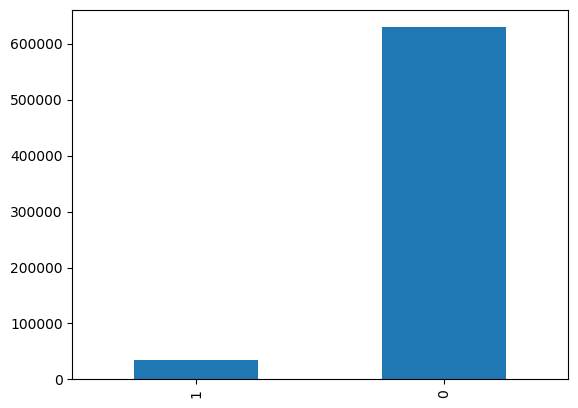

In [110]:
# target column
df["target"].value_counts().sort_values().plot(kind = 'bar')

Save preprocessed data:

In [111]:
print(f'Uploading pre-processed data here -> s3://{bucket}/{preprocessed_data}')
# df.to_csv(f's3://{bucket}/{preprocessed_data}/preprocessed_data.csv', index=False)

Uploading pre-processed data here -> s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes 2/Preprocessed-Data


In [112]:
# df.to_csv('preprocessed_data.csv')

Train-Test Split

In [113]:
#Split train-test data
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(df, test_size = 0.20, 
                                   stratify=df['target'],shuffle=True, random_state=42)


In [114]:
print('train_set:',train_set.shape)
print('test_set:',test_set.shape)

train_set: (531655, 71)
test_set: (132914, 71)


In [115]:
x = train_set.groupby(['mapped_employment_status_code'])['age'].quantile([0.01, 0.99]).unstack()
capping=x.reset_index()
capping

,mapped_employment_status_code,0.01,0.99
0,Active,23.00,69.00
1,DNM,23.24,69.69
2,Inactive,30.00,89.00
3,Non-Employee,15.00,96.00
4,TERM,21.00,70.00
5,Unknown,22.00,80.00


In [116]:
train_set = train_set.merge(capping, how='left', on='mapped_employment_status_code')
train_set.shape

(531655, 73)

In [117]:
train_set.rename(columns={0.01:'lower_age_cap',0.99:'upper_age_cap'},inplace=True)

In [118]:
train_set[['age','lower_age_cap','upper_age_cap']]

,age,lower_age_cap,upper_age_cap
0,44.0,23.0,69.0
1,51.0,23.0,69.0
2,45.0,23.0,69.0
3,39.0,21.0,70.0
4,29.0,30.0,89.0
...,...,...,...
531650,19.0,23.0,69.0
531651,48.0,23.0,69.0
531652,63.0,23.0,69.0
531653,46.0,23.0,69.0


In [119]:
train_set['age'] = np.where(train_set['age'] > train_set['upper_age_cap'], train_set['upper_age_cap'], train_set['age'])

In [120]:
train_set['age'] = np.where(train_set['age'] < train_set['lower_age_cap'], train_set['lower_age_cap'], train_set['age'])

In [121]:
# drop newly creating columns
col=['lower_age_cap','upper_age_cap']
train_set.drop(columns=col,axis=1,inplace=True)

In [122]:
train_num_columns = train_set.select_dtypes(include=['int']).columns

#### Numeric Imputer for missing values

In [123]:
class CustomNumericImputer:
    
    def __init__(self):
        return None
    
    def fit(self, X, impute_cols, using_cols, method='median'):
        self.using_cols = using_cols
        self.impute_cols = impute_cols
        self.method = method
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        
        if self.method == 'median':
            self.fit_values = X_.groupby(using_cols)[impute_cols].median().reset_index()
            impute_cols_rename_dict = dict([(x,x+'_median') for x in self.impute_cols])
            self.fit_values.rename(columns=impute_cols_rename_dict, inplace=True)
            self.fit_values.fillna(self.fit_values.median(), inplace=True)
        elif self.method == 'mean':
            self.fit_values = X_.groupby(using_cols)[impute_cols].mean().reset_index()
            impute_cols_rename_dict = dict([(x,x+'_mean') for x in self.impute_cols])
            self.fit_values.rename(columns=impute_cols_rename_dict, inplace=True)
            self.fit_values.fillna(self.fit_values.mean(), inplace=True)
        else: print('Method can be "median" or "mean"')
        self.new_cols = list(impute_cols_rename_dict.values())
        return self
    
    def fit_transform(self, X, impute_cols, using_cols, method='median'):
        self.fit(X, impute_cols, using_cols, method)
        
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        X_ = X_.merge(self.fit_values, how='left', on=self.using_cols)
        for col, ncol in zip(self.impute_cols, self.new_cols):
            X_[col] = np.where(X_[col].isnull(), X_[ncol], X_[col])
            
        if self.method == 'median':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].median())
        elif self.method == 'mean':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].mean())
    
    def transform(self, X, impute_cols):
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        X_ = X_.merge(self.fit_values, how='left', on=self.using_cols)
        for col, ncol in zip(self.impute_cols,self.new_cols):
            X_[col] = np.where(X_[col].isnull(), X_[ncol], X_[col])
            
        if self.method == 'median':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].median())
        elif self.method == 'mean':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].mean())
         

In [124]:
custom_numeric_imputer = CustomNumericImputer()

In [125]:
train_set[train_num_columns].describe()

,target
count,531655.000000
mean,0.053164
std,0.224361
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [126]:
train_float_columns = train_set.select_dtypes(include=['float']).columns

In [127]:
train_set[train_float_columns].describe()

,age
count,531581.000000
mean,47.114013
std,13.216735
min,15.000000
25%,36.000000
50%,47.000000
75%,58.000000
max,96.000000


In [128]:
train_set[train_float_columns] = custom_numeric_imputer.fit_transform(X=train_set, impute_cols=train_float_columns.tolist(),
                                                              using_cols=['mapped_employment_status_code'], method='median')

In [129]:
custom_numeric_imputer.fit_values

,mapped_employment_status_code,age_median
0,Active,47.0
1,DNM,58.5
2,Inactive,63.0
3,Non-Employee,62.0
4,TERM,37.0
5,Unknown,47.0


In [130]:
# # creating bins on the column base_pay_regular_expectedannualsalary and converting it into a range
# bins = [-1, 19999, 39999, 59999, 79999, 99999, 174999,249999, 999999999999]
# labels = ['<20,000', '20,000 - 39,999', '40,000 - 59,999', '60,000 - 79,999', '80,000 - 99,999', '100,000-174999', '175000-249999', '>250000']
# train_set['base_pay_regular_expected_annual_salary_range'] = pd.cut(x=train_set['base_pay_regular_expectedannualsalary'], bins=bins, labels=labels)

In [131]:
# train_set.info()

In [132]:
# #Let's drop some columns which are not required
# col = ['base_pay_regular_expectedannualsalary','base_pay_regular_expectedannualsalary_range']
# train_set.drop(columns=col,axis=1,inplace=True)

In [133]:
train_set.shape

(531655, 71)

In [134]:
train_set['age'] =train_set['age'].astype('int')

In [135]:
# train_set['base_pay_regular_expected_annual_salary_range'] =train_set['base_pay_regular_expected_annual_salary_range'].astype('object')

In [136]:
for col in num_cols:
    train_set[col] = np.where(train_set[col]<0, np.nan, train_set[col])

In [137]:
train_set[num_cols].isna().sum()/train_set.shape[0]

age    0.0
dtype: float64

In [138]:
train_set.dropna().shape[0]/train_set.shape[0]

1.0

In [139]:
train_set.dropna(inplace=True)
train_set.shape

(531655, 71)

In [140]:
train_set.isna().sum().sum()

0

In [141]:
train_set.drop(['mapped_employment_status_code'],inplace=True,axis=1)

In [142]:
train_cat_columns = train_set.select_dtypes(include=['object']).columns

In [143]:
train_str_columns = train_set.select_dtypes(include=['string']).columns

In [144]:
print(train_cat_columns)
print(train_num_columns)
print(train_float_columns)
print(train_str_columns)

Index(['gender', 'marital_status'], dtype='object')
Index(['target'], dtype='object')
Index(['age'], dtype='object')
Index(['preventive_visit_flag_yr_0', 'blood_glucose_test_flag_yr_0',
       'hypertension_flag_yr_0', 'obesity_flag_yr_0',
       'family_history_diabetes_flag_yr_0', 'physical_excercise_flag_yr_0',
       'dietary_counselling_flag_yr_0',
       'screening_diabetes_mellitus_flag_yr_0', 'sleep_apnea_flag_yr_0',
       'cushing_syndrome_flag_yr_0', 'acromegaly_flag_yr_0',
       'polyuria_flag_yr_0', 'nocturia_flag_yr_0', 'polydipsia_flag_yr_0',
       'ovarian_disorder_flag_yr_0', 'heart_disorder_flag_yr_0',
       'preventive_visit_flag_yr_1', 'blood_glucose_test_flag_yr_1',
       'hypertension_flag_yr_1', 'obesity_flag_yr_1',
       'family_history_diabetes_flag_yr_1', 'physical_excercise_flag_yr_1',
       'dietary_counselling_flag_yr_1',
       'screening_diabetes_mellitus_flag_yr_1', 'sleep_apnea_flag_yr_1',
       'cushing_syndrome_flag_yr_1', 'acromegaly_flag_yr_1

In [145]:
train_cat_columns = list(train_cat_columns)

In [146]:
train_cat_columns.extend(train_str_columns)

In [147]:
pd.get_dummies(data=train_set, columns=train_cat_columns, drop_first=True).shape

(531655, 67)

In [148]:
train_set = pd.get_dummies(data=train_set, columns=train_cat_columns, drop_first=True)
train_set.shape

(531655, 67)

In [149]:
train_set.isna().sum().sum()

0

In [150]:
train_set.head(2)

,age,target,gender_Male,gender_Unknown,marital_status_Married,marital_status_Single,marital_status_Unknown,preventive_visit_flag_yr_0_Yes,blood_glucose_test_flag_yr_0_Yes,hypertension_flag_yr_0_Yes,obesity_flag_yr_0_Yes,family_history_diabetes_flag_yr_0_Yes,physical_excercise_flag_yr_0_Yes,dietary_counselling_flag_yr_0_Yes,screening_diabetes_mellitus_flag_yr_0_Yes,cushing_syndrome_flag_yr_0_Yes,acromegaly_flag_yr_0_Yes,nocturia_flag_yr_0_Yes,polydipsia_flag_yr_0_Yes,ovarian_disorder_flag_yr_0_Yes,heart_disorder_flag_yr_0_Yes,preventive_visit_flag_yr_1_Yes,blood_glucose_test_flag_yr_1_Yes,hypertension_flag_yr_1_Yes,obesity_flag_yr_1_Yes,family_history_diabetes_flag_yr_1_Yes,physical_excercise_flag_yr_1_Yes,dietary_counselling_flag_yr_1_Yes,screening_diabetes_mellitus_flag_yr_1_Yes,cushing_syndrome_flag_yr_1_Yes,acromegaly_flag_yr_1_Yes,nocturia_flag_yr_1_Yes,polydipsia_flag_yr_1_Yes,ovarian_disorder_flag_yr_1_Yes,heart_disorder_flag_yr_1_Yes,preventive_visit_flag_yr_Yes,blood_glucose_test_flag_yr_Yes,hypertension_flag_yr_Yes,obesity_flag_yr_Yes,family_history_diabetes_flag_yr_Yes,physical_excercise_flag_yr_Yes,dietary_counselling_flag_yr_Yes,screening_diabetes_mellitus_flag_yr_Yes,cushing_syndrome_flag_yr_Yes,acromegaly_flag_yr_Yes,nocturia_flag_yr_Yes,polydipsia_flag_yr_Yes,ovarian_disorder_flag_yr_Yes,heart_disorder_flag_yr_Yes,specialist_ind_Yes,primary_care_ind_Yes,physician_ind_Yes,unknown_ind_Yes,durable_medical_ind_Yes,lab_visit_ind_Yes,specialist_ind_y0_Yes,primary_care_ind_y0_Yes,physician_ind_y0_Yes,unknown_ind_y0_Yes,durable_medical_ind_y0_Yes,lab_visit_ind_y0_Yes,specialist_ind_y1_Yes,primary_care_ind_y1_Yes,physician_ind_y18_Yes,unknown_ind_y1_Yes,durable_medical_ind_y1_Yes,lab_visit_ind_y1_Yes
0,44.0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,0,1
1,51.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Uploading train set to S3:

In [151]:
print(f'Uploading pre-processed data here -> s3://{bucket}/{preprocessed_data}')
# train_set.to_csv(f's3://{bucket}/{preprocessed_data}/train_data_w_dummy.csv', index=False)

Uploading pre-processed data here -> s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes 2/Preprocessed-Data


In [152]:
train_set.to_csv('train_data_w_dummy.csv')

In [153]:
# train_set.columns

Preprocessing Test Set

In [154]:
test_set = test_set.merge(capping, how='left', on='mapped_employment_status_code')
test_set.shape

(132914, 73)

In [155]:
test_set.rename(columns={0.01:'lower_age_cap',0.99:'upper_age_cap'},inplace=True)

In [156]:
test_set['age'] = np.where(test_set['age'] > test_set['upper_age_cap'], test_set['upper_age_cap'], test_set['age'])

In [157]:
test_set['age'] = np.where(test_set['age'] < test_set['lower_age_cap'], test_set['lower_age_cap'], test_set['age'])

In [158]:
col=['lower_age_cap','upper_age_cap']
test_set.drop(columns=col,axis=1,inplace=True)

In [159]:
test_num_columns = test_set.select_dtypes(include=['int']).columns

In [160]:
test_float_columns = test_set.select_dtypes(include=['float']).columns

#### Numeric Imputer

In [161]:
test_set[test_float_columns] = custom_numeric_imputer.transform(X=test_set, impute_cols=test_float_columns)
test_set.shape

(132914, 71)

In [162]:
test_set[test_float_columns].isna().sum()

age    0
dtype: int64

In [163]:
# # creating bins on the column base_pay_regular_expectedannualsalary and converting it into a range
# bins = [-1, 19999, 39999, 59999, 79999, 99999, 174999,249999, 999999999999]
# labels = ['<20,000', '20,000 - 39,999', '40,000 - 59,999', '60,000 - 79,999', '80,000 - 99,999', '100,000-174999', '175000-249999', '>250000']
# test_set['base_pay_regular_expected_annual_salary_range'] = pd.cut(x=test_set['base_pay_regular_expectedannualsalary'], bins=bins, labels=labels)

In [164]:
test_set['age'] = test_set['age'].astype(int)

In [165]:
# test_set['base_pay_regular_expected_annual_salary_range'] = test_set['base_pay_regular_expected_annual_salary_range'].astype('object')

In [166]:
test_set.shape

(132914, 71)

In [167]:
test_set.isna().sum()

preventive_visit_flag_yr_0           0
blood_glucose_test_flag_yr_0         0
hypertension_flag_yr_0               0
obesity_flag_yr_0                    0
family_history_diabetes_flag_yr_0    0
                                    ..
age                                  0
gender                               0
marital_status                       0
mapped_employment_status_code        0
target                               0
Length: 71, dtype: int64

In [168]:
# col = ['base_pay_regular_expectedannualsalary','base_pay_regular_expectedannualsalary_range']
# test_set=test_set.drop(columns=col,axis=1)

In [169]:
test_set.shape

(132914, 71)

In [170]:
for col in num_cols:
    test_set[col] = np.where(test_set[col]<0, np.nan, test_set[col])

In [171]:
test_set[num_cols].isna().sum()/test_set.shape[0]

age    0.0
dtype: float64

In [172]:
test_set.dropna().shape[0]/test_set.shape[0]

1.0

In [173]:
test_set.dropna(inplace=True)
test_set.shape

(132914, 71)

In [174]:
test_set.drop(['mapped_employment_status_code'],inplace=True,axis=1)

In [175]:
test_cat_columns = test_set.select_dtypes(include=['object']).columns

In [176]:
test_str_columns = test_set.select_dtypes(include=['string']).columns

In [177]:
print(test_cat_columns)
print(test_num_columns)
print(test_float_columns)
print(test_str_columns)

Index(['gender', 'marital_status'], dtype='object')
Index(['target'], dtype='object')
Index(['age'], dtype='object')
Index(['preventive_visit_flag_yr_0', 'blood_glucose_test_flag_yr_0',
       'hypertension_flag_yr_0', 'obesity_flag_yr_0',
       'family_history_diabetes_flag_yr_0', 'physical_excercise_flag_yr_0',
       'dietary_counselling_flag_yr_0',
       'screening_diabetes_mellitus_flag_yr_0', 'sleep_apnea_flag_yr_0',
       'cushing_syndrome_flag_yr_0', 'acromegaly_flag_yr_0',
       'polyuria_flag_yr_0', 'nocturia_flag_yr_0', 'polydipsia_flag_yr_0',
       'ovarian_disorder_flag_yr_0', 'heart_disorder_flag_yr_0',
       'preventive_visit_flag_yr_1', 'blood_glucose_test_flag_yr_1',
       'hypertension_flag_yr_1', 'obesity_flag_yr_1',
       'family_history_diabetes_flag_yr_1', 'physical_excercise_flag_yr_1',
       'dietary_counselling_flag_yr_1',
       'screening_diabetes_mellitus_flag_yr_1', 'sleep_apnea_flag_yr_1',
       'cushing_syndrome_flag_yr_1', 'acromegaly_flag_yr_1

In [178]:
test_cat_columns = list(test_cat_columns)

In [179]:
test_cat_columns.extend(test_str_columns)

In [180]:
test_set = pd.get_dummies(data=test_set, columns=test_cat_columns, drop_first=True)
test_set.shape

(132914, 67)

In [181]:
test_set = test_set.reindex(columns=train_set.columns, fill_value=0)
test_set.shape

(132914, 67)

In [182]:
test_set.isna().sum().sum()

0

In [183]:
test_set.head(2)

,age,target,gender_Male,gender_Unknown,marital_status_Married,marital_status_Single,marital_status_Unknown,preventive_visit_flag_yr_0_Yes,blood_glucose_test_flag_yr_0_Yes,hypertension_flag_yr_0_Yes,obesity_flag_yr_0_Yes,family_history_diabetes_flag_yr_0_Yes,physical_excercise_flag_yr_0_Yes,dietary_counselling_flag_yr_0_Yes,screening_diabetes_mellitus_flag_yr_0_Yes,cushing_syndrome_flag_yr_0_Yes,acromegaly_flag_yr_0_Yes,nocturia_flag_yr_0_Yes,polydipsia_flag_yr_0_Yes,ovarian_disorder_flag_yr_0_Yes,heart_disorder_flag_yr_0_Yes,preventive_visit_flag_yr_1_Yes,blood_glucose_test_flag_yr_1_Yes,hypertension_flag_yr_1_Yes,obesity_flag_yr_1_Yes,family_history_diabetes_flag_yr_1_Yes,physical_excercise_flag_yr_1_Yes,dietary_counselling_flag_yr_1_Yes,screening_diabetes_mellitus_flag_yr_1_Yes,cushing_syndrome_flag_yr_1_Yes,acromegaly_flag_yr_1_Yes,nocturia_flag_yr_1_Yes,polydipsia_flag_yr_1_Yes,ovarian_disorder_flag_yr_1_Yes,heart_disorder_flag_yr_1_Yes,preventive_visit_flag_yr_Yes,blood_glucose_test_flag_yr_Yes,hypertension_flag_yr_Yes,obesity_flag_yr_Yes,family_history_diabetes_flag_yr_Yes,physical_excercise_flag_yr_Yes,dietary_counselling_flag_yr_Yes,screening_diabetes_mellitus_flag_yr_Yes,cushing_syndrome_flag_yr_Yes,acromegaly_flag_yr_Yes,nocturia_flag_yr_Yes,polydipsia_flag_yr_Yes,ovarian_disorder_flag_yr_Yes,heart_disorder_flag_yr_Yes,specialist_ind_Yes,primary_care_ind_Yes,physician_ind_Yes,unknown_ind_Yes,durable_medical_ind_Yes,lab_visit_ind_Yes,specialist_ind_y0_Yes,primary_care_ind_y0_Yes,physician_ind_y0_Yes,unknown_ind_y0_Yes,durable_medical_ind_y0_Yes,lab_visit_ind_y0_Yes,specialist_ind_y1_Yes,primary_care_ind_y1_Yes,physician_ind_y18_Yes,unknown_ind_y1_Yes,durable_medical_ind_y1_Yes,lab_visit_ind_y1_Yes
0,68.0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,1,1,0,0,0,0,1
1,40.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Uploading test data to S3:

In [184]:
print(f'Uploading pre-processed data here -> s3://{bucket}/{preprocessed_data}')
# test_set.to_csv(f's3://{bucket}/{preprocessed_data}/test_data_w_dummy.csv', index=False)

Uploading pre-processed data here -> s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes 2/Preprocessed-Data


In [185]:
test_set.to_csv('test_data_w_dummy.csv')

In [186]:
# test_set.columns

## Checking linearity of the data

In [187]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.preprocessing import normalize

In [188]:
def computePCA(data) :
    
    pca = PCA() # Compute PCA
    data_pca = pca.fit_transform(data) # Fit and transform data
    eigenvalues = pca.explained_variance_ # Get eigenvalues
    eigenvalues = np.round(eigenvalues, 5) # Round off eigenvalues
    
    return data_pca, eigenvalues

In [189]:
train_pca, train_eigen = computePCA(train_set)

print("Eigen values of train data: ", train_eigen.tolist())

Eigen values of train data:  [174.80454, 1.17423, 0.47533, 0.4531, 0.41744, 0.29669, 0.2831, 0.26107, 0.23019, 0.21616, 0.17628, 0.14698, 0.12566, 0.11499, 0.10565, 0.09805, 0.0962, 0.08107, 0.06693, 0.06633, 0.05641, 0.04639, 0.04388, 0.03605, 0.03331, 0.03166, 0.02707, 0.0258, 0.02212, 0.02169, 0.00842, 0.00612, 0.0024, 0.00064, 0.00054, 0.00021, 0.00013, 0.0001, 4e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [190]:
test_pca, test_eigen = computePCA(test_set)

print("Eigen values of test data: ", test_eigen.tolist())

Eigen values of test data:  [174.55262, 1.17289, 0.47529, 0.45356, 0.41954, 0.29525, 0.28548, 0.26102, 0.23144, 0.21547, 0.17624, 0.14643, 0.12551, 0.11402, 0.10524, 0.09803, 0.09734, 0.08152, 0.06805, 0.06655, 0.05652, 0.04654, 0.04437, 0.03535, 0.03378, 0.03186, 0.02857, 0.02597, 0.02263, 0.02109, 0.0083, 0.00582, 0.00245, 0.00073, 0.00045, 0.00038, 0.00016, 7e-05, 6e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [191]:
# fig = plt.figure(figsize= (30, 20))
# ax = fig.add_subplot(131,projection='3d')
# ax.scatter(train_set.iloc[:,3], train_set.iloc[:,4], train_set.iloc[:,5], marker= '.', color= '#2ade2a', s= 28, alpha= 0.4)
# ax.set_title("Linear Data", fontsize= 20)

In [192]:
train_pca.shape

(531655, 67)

In [193]:
test_pca.shape

(132914, 67)

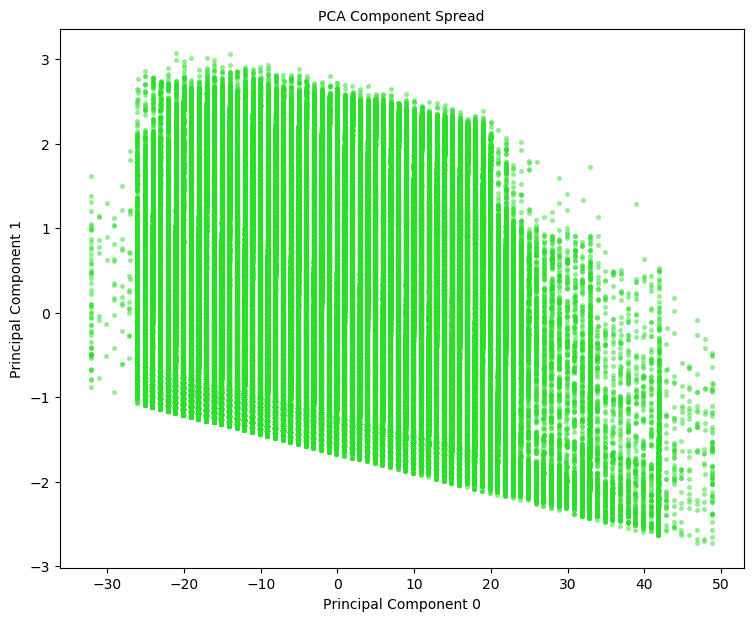

In [194]:
fig = plt.figure(figsize= (30, 7))

ax = fig.add_subplot(131) # PCA linear data
ax.scatter(train_pca[:,0], train_pca[:,1], marker= '.', color= '#2ade2a', s= 28, alpha= 0.4)
ax.set_title("PCA Component Spread", fontsize= 10)
ax.set_xlabel("Principal Component 0", fontsize= 10)
ax.set_ylabel("Principal Component 1", fontsize= 10)
plt.show()

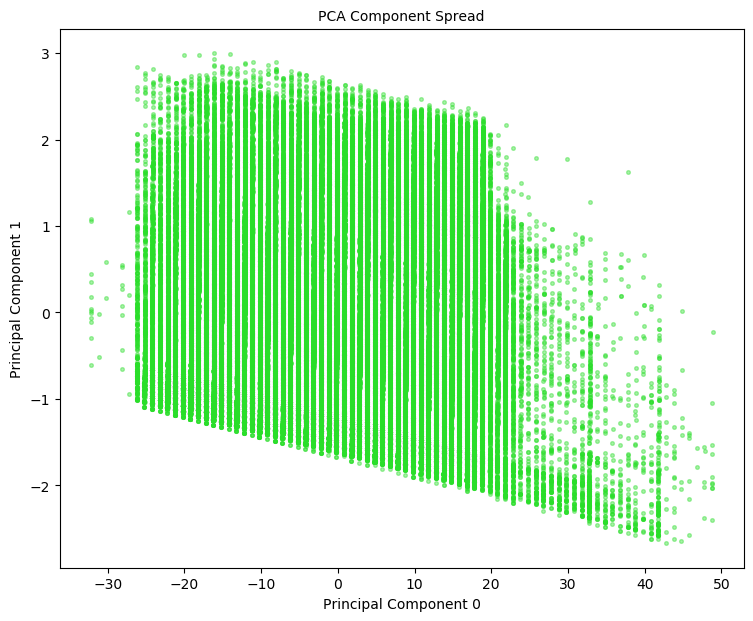

In [195]:
fig = plt.figure(figsize= (30, 7))

ax = fig.add_subplot(131) # PCA linear data
ax.scatter(test_pca[:,0], test_pca[:,1], marker= '.', color= '#2ade2a', s= 28, alpha= 0.4)
ax.set_title("PCA Component Spread", fontsize= 10)
ax.set_xlabel("Principal Component 0", fontsize= 10)
ax.set_ylabel("Principal Component 1", fontsize= 10)
plt.show()